In [136]:
import random

import numpy as np
import pandas as pd
from scipy.fft import rfft
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['axes.grid'] = False
plt.rcParams['savefig.facecolor']= 'w'  # 保证保存的图片不透明.

In [137]:
def set_random_seed(seed, deterministic=False):
    '''设置随机种子, 尽量固定torch的结果.'''
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        
set_random_seed(114514810)

from pathlib import Path
def save_fig(filename, fig=None):
    if fig is None:
        fig = plt.gcf()
    dirpath = Path('./fig')
    if not dirpath.exists():
        dirpath.mkdir()
    filepath = dirpath / filename
    fig.savefig(str(filepath), dpi=200, bbox_inches='tight')

In [138]:
# 从第5行开始, 每6条记录选中一条.
df = pd.read_csv('jena_climate_2009_2016.csv')[5::6]
df.index = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


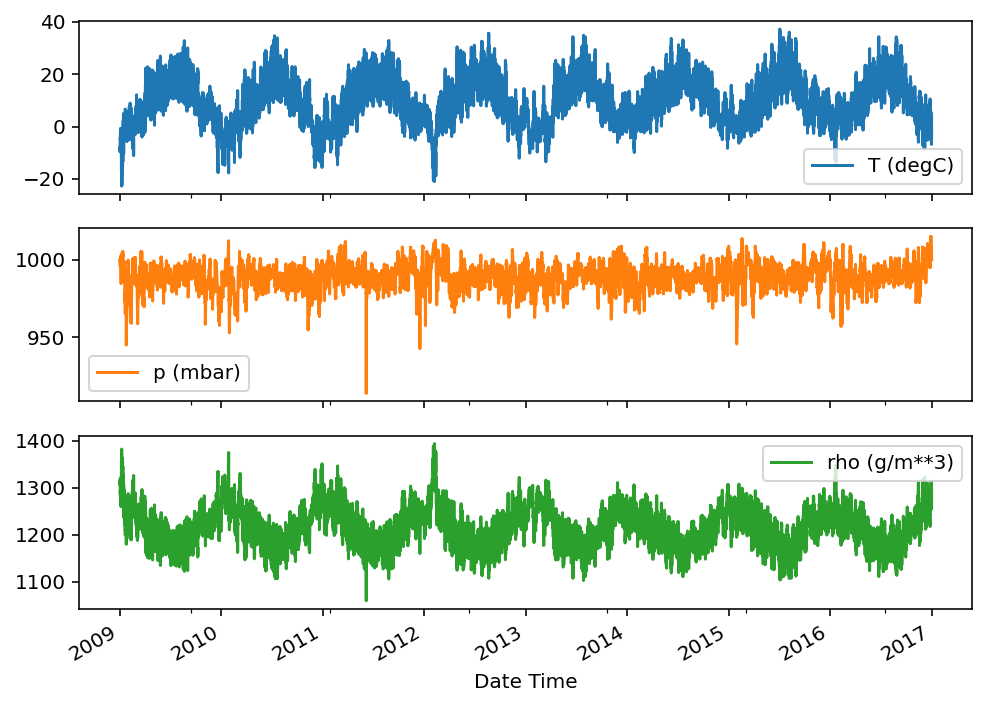

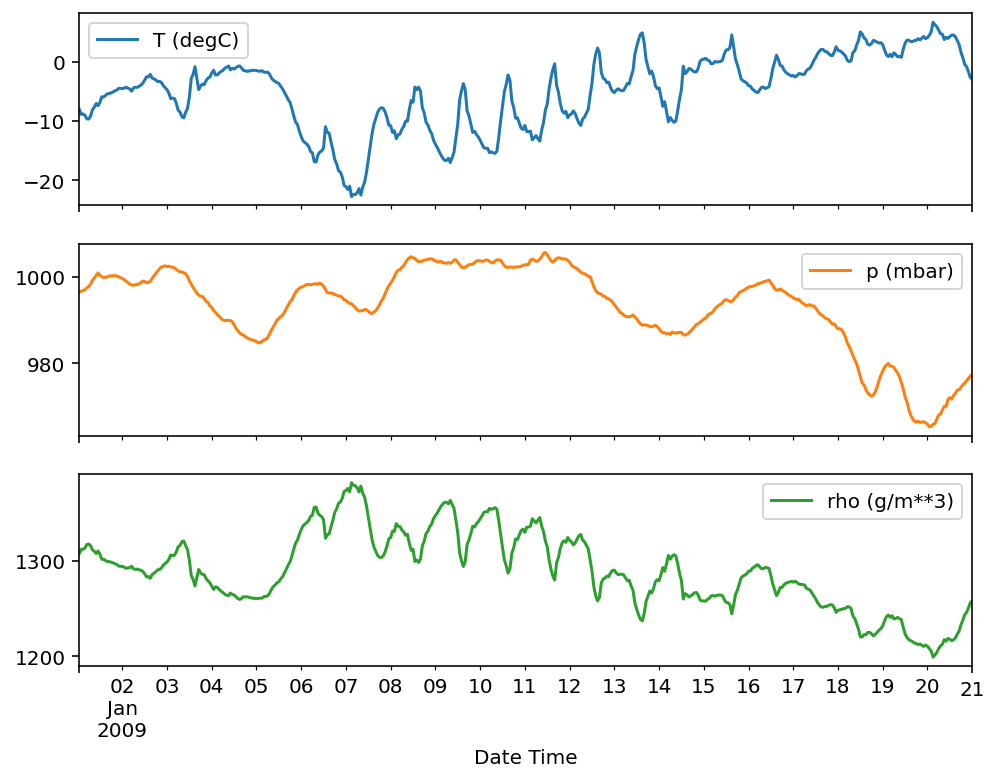

In [139]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.plot(subplots=True)
save_fig('features_timeseries_1.png')

plot_features = df[plot_cols][:480]
plot_features.plot(subplots=True)
save_fig('features_timeseries_2.png')

In [140]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


In [141]:
df['wv (m/s)'] = df['wv (m/s)'].clip(lower=0)
df['max. wv (m/s)'] = df['max. wv (m/s)'].clip(lower=0)

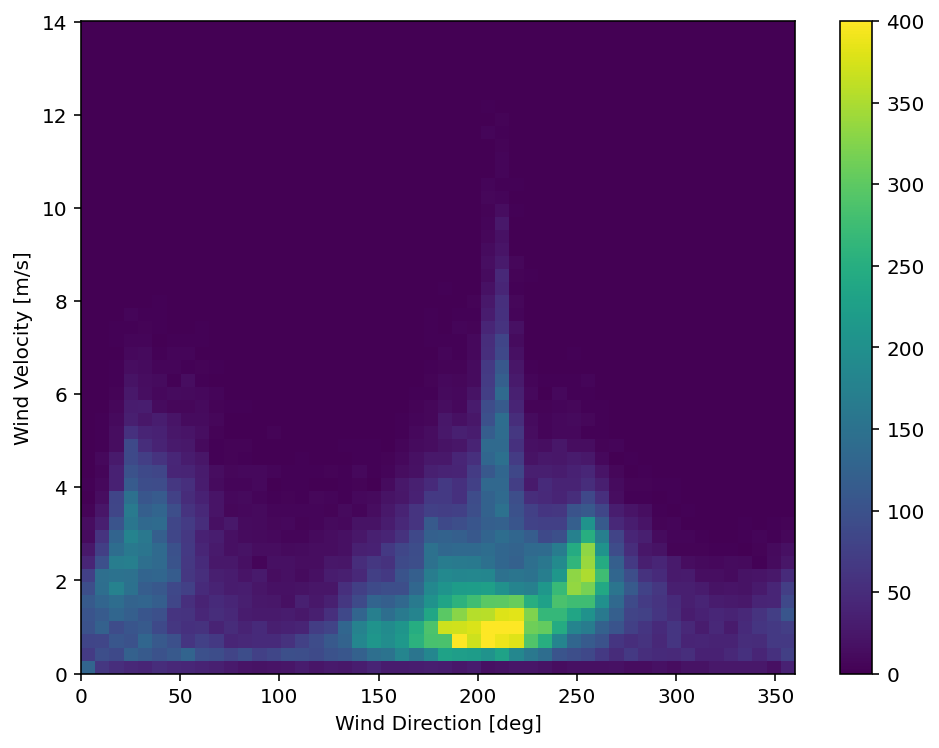

In [142]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmin=0, vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')
save_fig('wind_distribution_1.png')

In [143]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# 风向转为极坐标的风向, 单位转为弧度.
wd_rad = np.deg2rad(270 - df.pop('wd (deg)'))

# 计算风速的xy分量.
df['Wx'] = wv * np.cos(wd_rad)
df['Wy'] = wv * np.sin(wd_rad)

# 计算最大风速的xy分量.
df['max Wx'] = max_wv * np.cos(wd_rad)
df['max Wy'] = max_wv * np.sin(wd_rad)

(-7.733831295546779, 8.27438540335515, -8.244699285490789, 11.305513973134666)

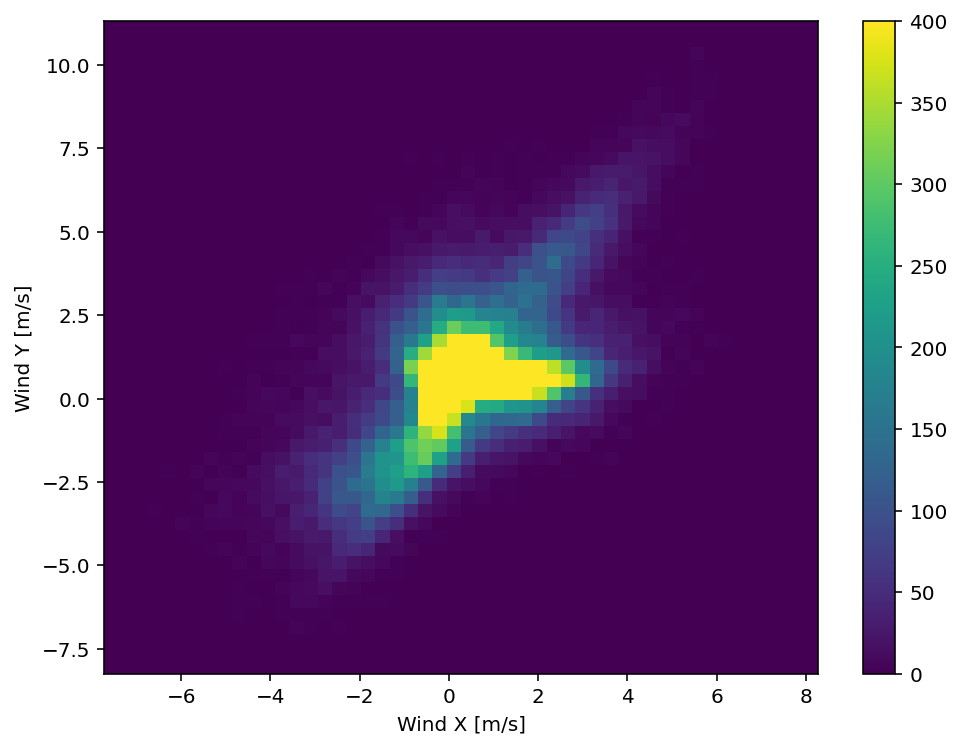

In [144]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmin=0, vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
plt.axis('tight')
# save_fig('wind_distribution_2.png')

In [145]:
timestamp_s = df.index.map(pd.Timestamp.timestamp)

In [146]:
day = 24 * 60 * 60
year = 365.2425 * day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

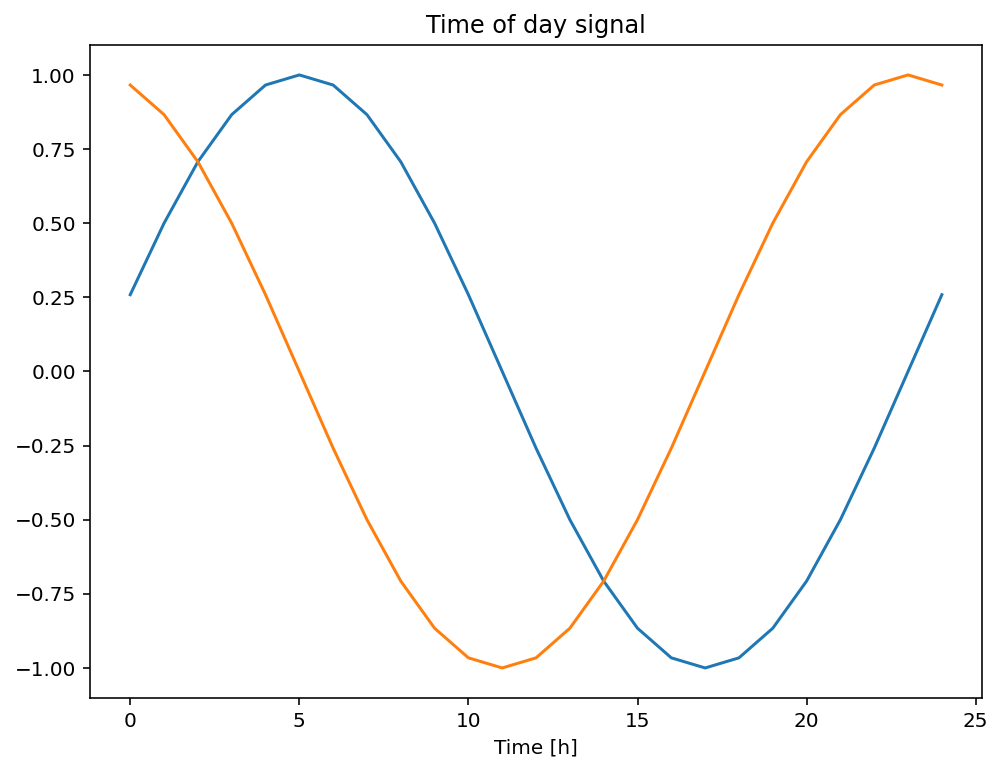

In [147]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')
# save_fig('time_signal.png')

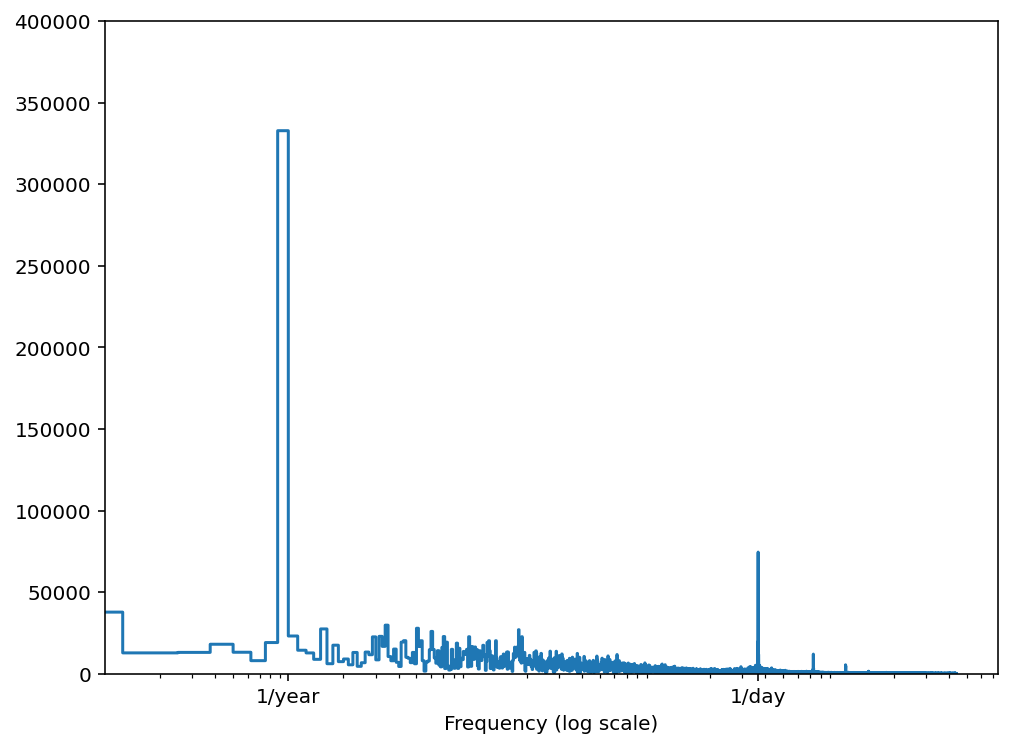

In [148]:
fft = rfft(df['T (degC)'].to_numpy())
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24 * 365.2524
years_per_dataset = n_samples_h / hours_per_year

f_per_year = f_per_dataset / years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')
# save_fig('rfft.png')

In [149]:
n = len(df)
i1 = int(n * 0.7)
i2 = int(n * 0.9)
train_df = df.iloc[:i1]
val_df = df.iloc[i1:i2]
test_df = df.iloc[i2:]

num_features = df.shape[1]

In [150]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

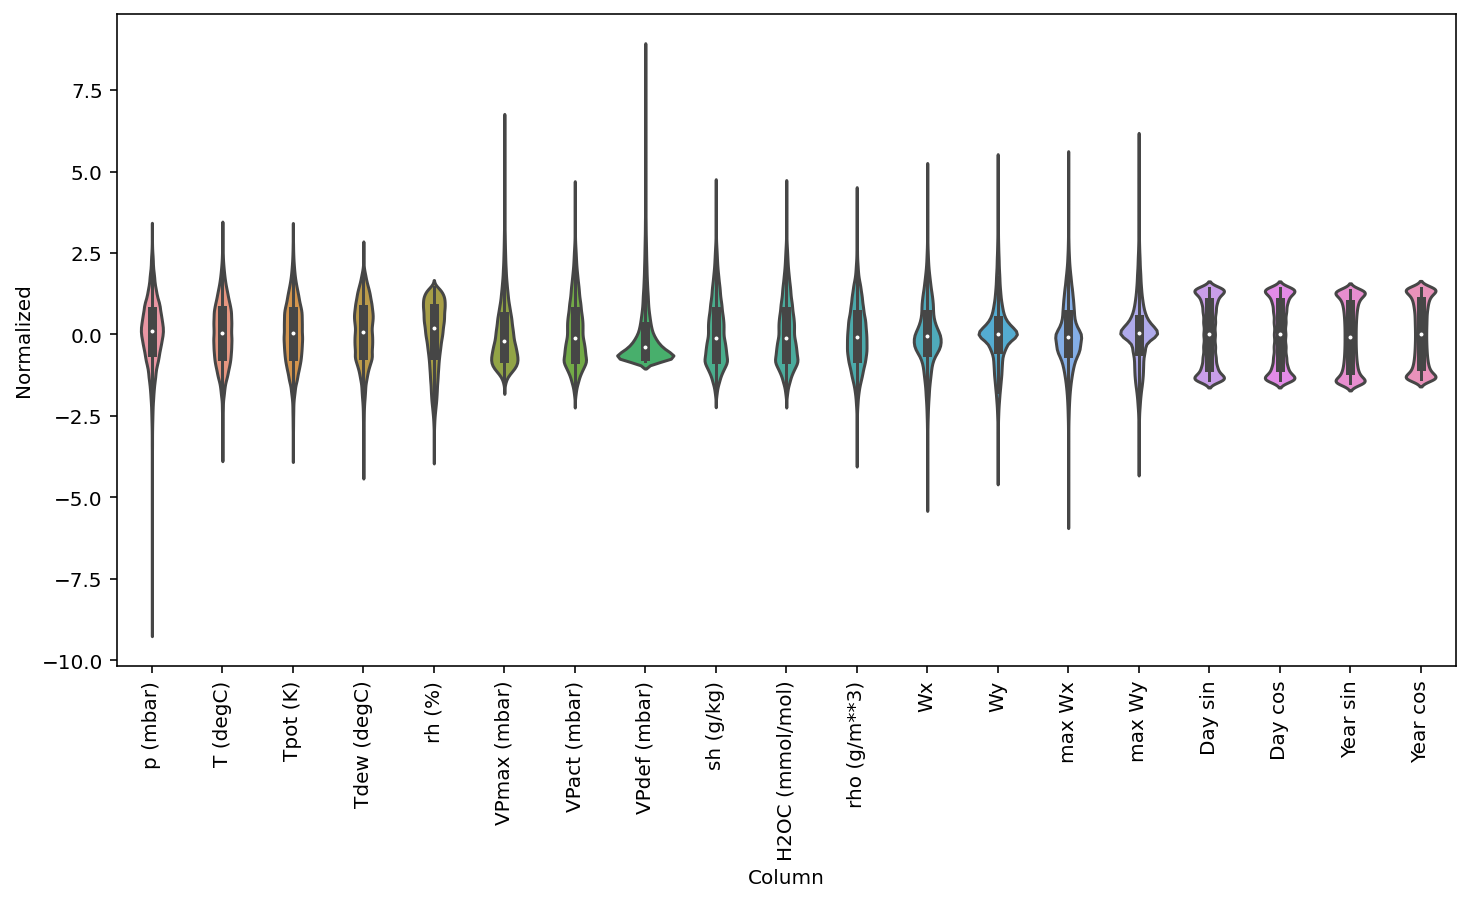

In [151]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)
# save_fig('violinplot.png')

In [152]:
class WindowGenerator:
    def __init__(
        self, input_width, label_width, shift,
        train_df=train_df, val_df=val_df, test_df=test_df,
        label_columns=None
    ):
        # 存储原始数据.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # 找出标签列的下标索引.
        self.columns = train_df.columns
        if label_columns is None:
            self.label_columns = self.columns
        else:
            self.label_columns = pd.Index(label_columns)
        self.label_column_indices = [
            self.columns.get_loc(name) for name in self.label_columns
        ]
        
        # 计算窗口的参数.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(input_width)
        self.input_indices = np.arange(input_width)
        
        self.label_start = self.total_window_size - label_width
        self.label_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.label_start, self.total_window_size)

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column names(s): {self.label_columns.to_list()}'
        ])

In [153]:
w1 = WindowGenerator(
    input_width=24,
    label_width=1,
    shift=24,
    label_columns=['T (degC)']
)
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column names(s): ['T (degC)']

In [154]:
w2 = WindowGenerator(
    input_width=6,
    label_width=1,
    shift=1,
    label_columns=['T (degC)']
)
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column names(s): ['T (degC)']

In [155]:
def split_window(self, features):
    inputs = features[self.input_slice, :]
    labels = features[self.label_slice, self.label_column_indices]
    
    return inputs, labels

WindowGenerator.split_window = split_window 

In [156]:
example_window = train_df.iloc[:w2.total_window_size].to_numpy()
example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (time, features)
Window shape: (7, 19)
Inputs shape: (6, 19)
Labels shape: (1, 1)


In [157]:
class TimeseriesDataset(Dataset):
    def __init__(self, data, window, transform=None):
        self.data = torch.tensor(data, dtype=torch.float)
        self.window = window
        self.transform = transform
    
    def __len__(self):
        return len(self.data) - self.window + 1
    
    def __getitem__(self, index):
        if index < 0:
            index += len(self)
        features = self.data[index:index+self.window]
        if self.transform is not None:
            features = self.transform(features)
            
        return features

def make_dataloader(self, df):
    data = df.to_numpy()
    dataset = TimeseriesDataset(
        data=data,
        window=self.total_window_size,
        transform=self.split_window
    )
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=32,
        shuffle=True
    )
    
    return dataloader

WindowGenerator.make_dataloader = make_dataloader

In [158]:
@property
def train(self):
    return self.make_dataloader(self.train_df)

@property
def val(self):
    return self.make_dataloader(self.val_df)

@property
def test(self):
    return self.make_dataloader(self.test_df)
    
@property
def example(self):
    '''获取并缓存一个批次的(inputs, labels)窗口.'''
    result = getattr(self, '_example', None)
    if result is None:
        result = next(iter(self.train))
        self._example = result
    
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [159]:
example_inputs, example_labels = w2.example
print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): torch.Size([32, 6, 19])
Labels shape (batch, time, features): torch.Size([32, 1, 1])


In [160]:
def tensor_to_numpy(tensor):
    '''张量转为NumPy数组.'''
    if tensor.requires_grad:
        tensor = tensor.detach()
    if tensor.device.type == 'cuda':
        tensor = tensor.cpu()

    return tensor.numpy()

def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    # 从缓存的一批窗口中获取输入和标签.
    inputs, labels = self.example
    if model is not None:
        model.eval()
        with torch.no_grad():
            predictions = tensor_to_numpy(model(inputs))
    inputs = tensor_to_numpy(inputs)
    labels = tensor_to_numpy(labels)
    
    plt.figure(figsize=(12, 8))
    plot_col_index = self.columns.get_loc(plot_col)
    max_n = min(max_subplots, len(inputs))
    
    # 子图数量不超过max_subplots和批大小.
    for n in range(max_n):
        plt.subplot(max_n, 1, n + 1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(
            self.input_indices, inputs[n, :, plot_col_index],
            label='Inputs', marker='.', zorder=1
        )
        
        # 标签窗口里没有plot_col时则跳过.
        try:
            label_col_index = self.label_columns.get_loc(plot_col)
        except KeyError:
            continue
    
        plt.scatter(
            self.label_indices, labels[n, :, label_col_index],
            c='#2ca02c', edgecolors='k', label='Labels'
        )
        
        # 画出预测值.
        if model is not None:
            plt.scatter(
                self.label_indices, predictions[n, :, label_col_index],
                c='#ff7f0e', s=64, marker='X', edgecolors='k',
                label='Predictions'
            )
        
        if n == 0:
            plt.legend()
    
    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

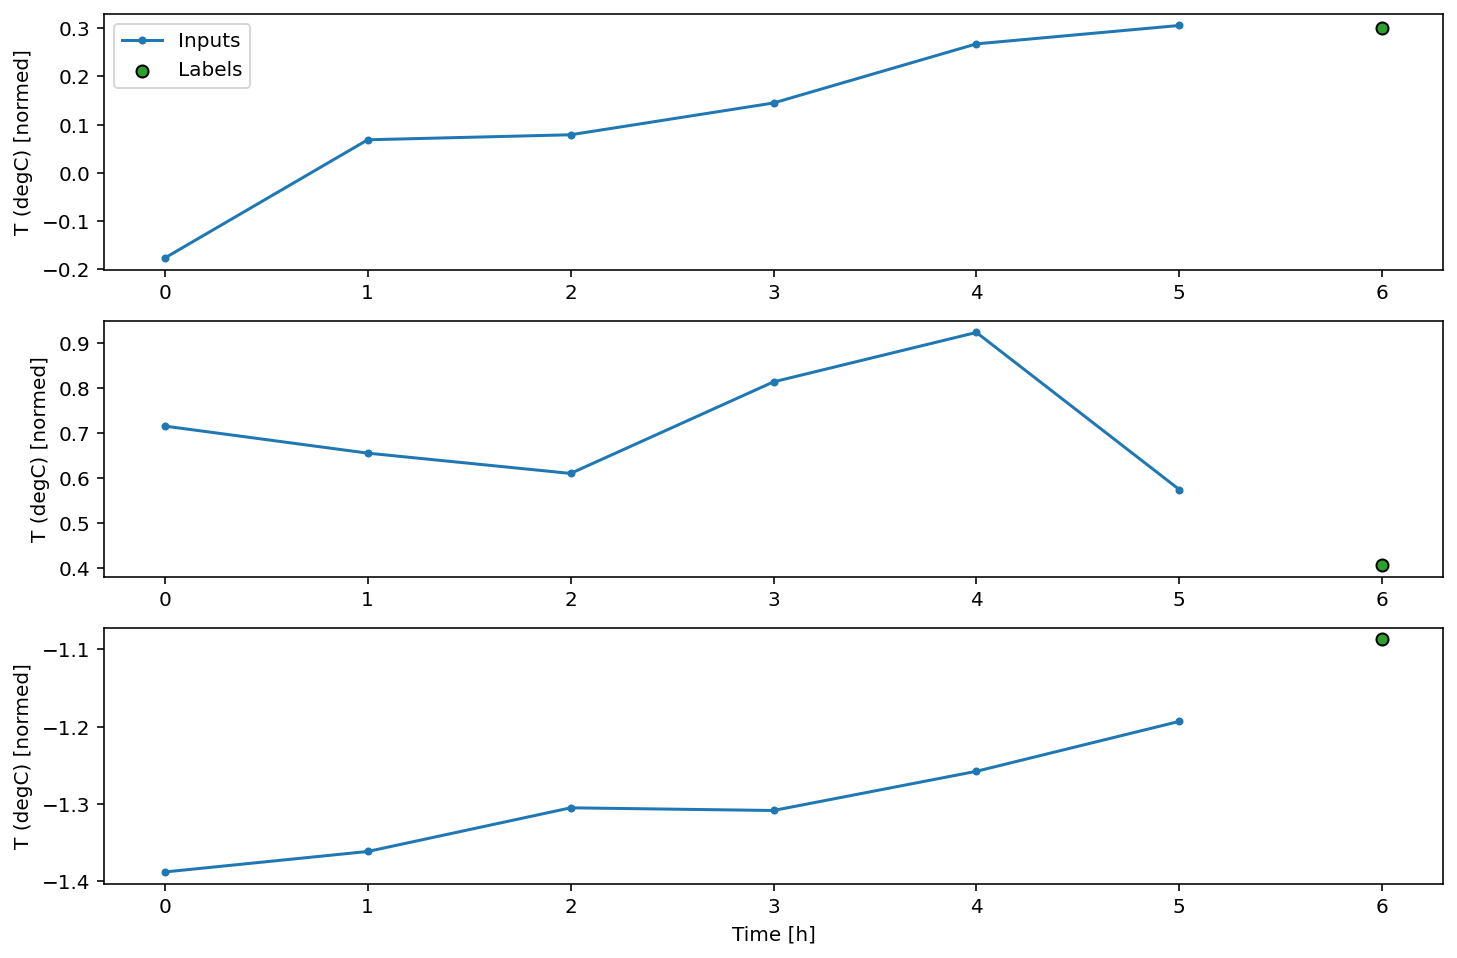

In [177]:
w2.plot()
# save_fig('plot_method_1.png')

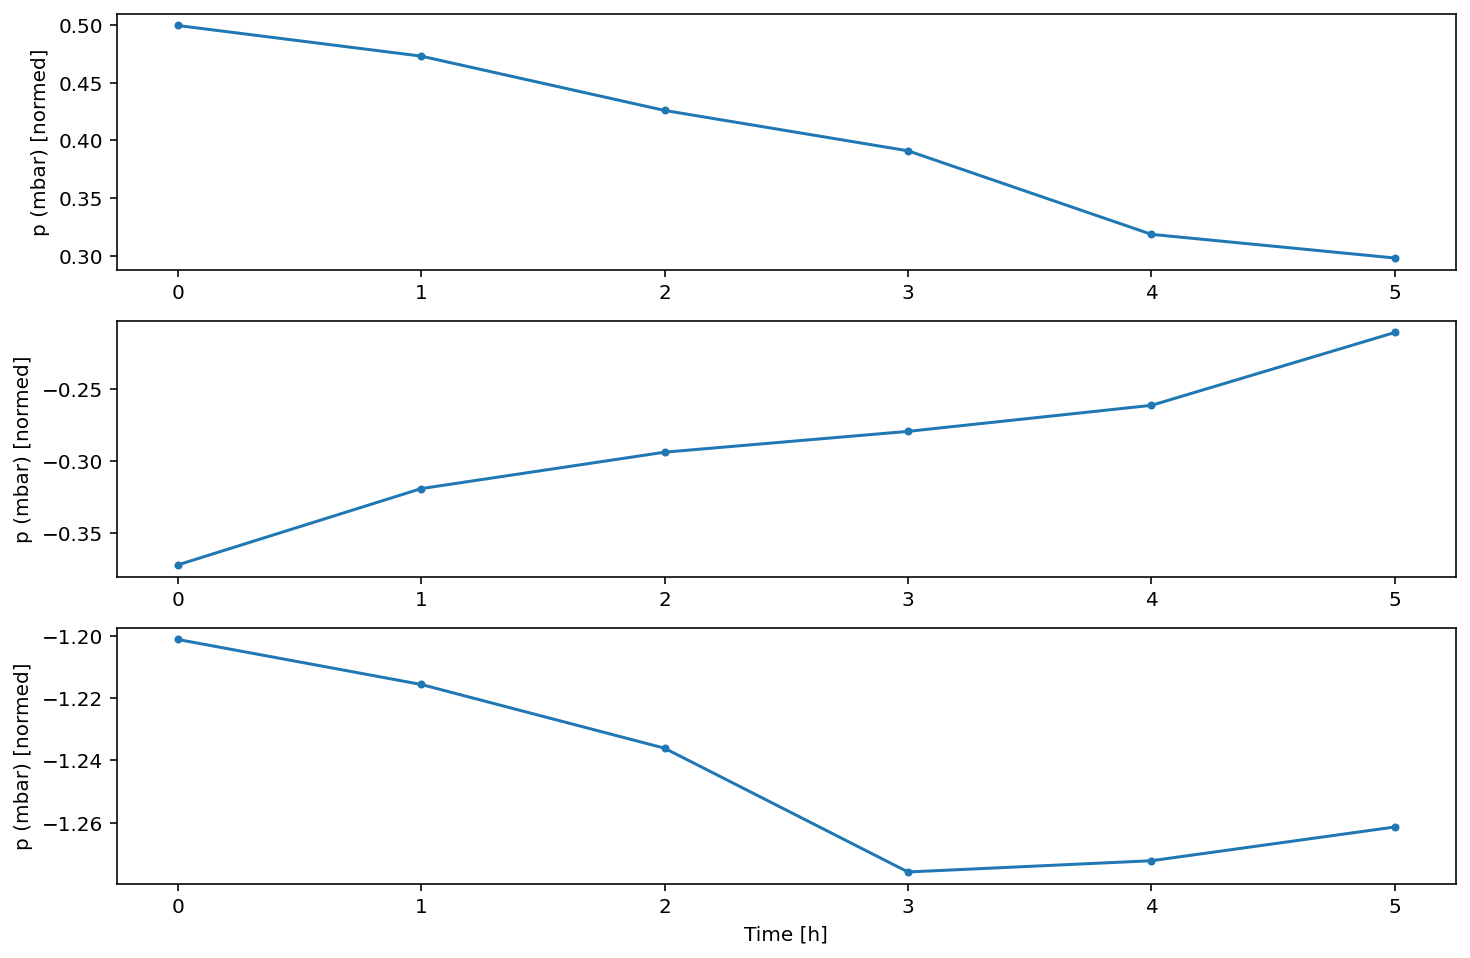

In [178]:
w2.plot(plot_col='p (mbar)')
# save_fig('plot_method_2.png')

In [163]:
class WindowGenerator:
    def __init__(
        self, input_width, label_width, shift,
        train_df=train_df, val_df=val_df, test_df=test_df,
        label_columns=None
    ):
        # 存储原始数据.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # 找出标签列的下标索引.
        self.columns = train_df.columns
        if label_columns is None:
            self.label_columns = self.columns
        else:
            self.label_columns = pd.Index(label_columns)
        self.label_column_indices = [
            self.columns.get_loc(name) for name in self.label_columns
        ]
        
        # 计算窗口的参数.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(input_width)
        self.input_indices = np.arange(input_width)
        
        self.label_start = self.total_window_size - label_width
        self.label_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.label_start, self.total_window_size)

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column names(s): {self.label_columns.to_list()}'
        ])

    def split_window(self, features):
        inputs = features[self.input_slice, :]
        labels = features[self.label_slice, self.label_column_indices]
        
        return inputs, labels

    def make_dataloader(self, df):
        data = df.to_numpy()
        dataset = TimeseriesDataset(
            data=data,
            window=self.total_window_size,
            transform=self.split_window
        )
        dataloader = DataLoader(
            dataset=dataset,
            batch_size=32,
            shuffle=True
        )
        
        return dataloader

    @property
    def train(self):
        return self.make_dataloader(self.train_df)

    @property
    def val(self):
        return self.make_dataloader(self.val_df)

    @property
    def test(self):
        return self.make_dataloader(self.test_df)
        
    @property
    def example(self):
        '''获取并缓存一个批次的(inputs, labels)窗口.'''
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        
        return result

    def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
        # 从缓存的一批窗口中获取输入和标签.
        inputs, labels = self.example
        if model is not None:
            model.eval()
            with torch.no_grad():
                predictions = tensor_to_numpy(model(inputs))
        inputs = tensor_to_numpy(inputs)
        labels = tensor_to_numpy(labels)
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.columns.get_loc(plot_col)
        max_n = min(max_subplots, len(inputs))
        
        # 子图数量不超过max_subplots和批大小.
        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(
                self.input_indices, inputs[n, :, plot_col_index],
                label='Inputs', marker='.', zorder=1
            )
            
            # 标签窗口里没有plot_col时则跳过.
            try:
                label_col_index = self.label_columns.get_loc(plot_col)
            except KeyError:
                continue
        
            plt.scatter(
                self.label_indices, labels[n, :, label_col_index],
                c='#2ca02c', edgecolors='k', label='Labels'
            )
            
            # 画出预测值.
            if model is not None:
                plt.scatter(
                    self.label_indices, predictions[n, :, label_col_index],
                    c='#ff7f0e', s=64, marker='X', edgecolors='k',
                    label='Predictions'
                )
            
            if n == 0:
                plt.legend()
        
        plt.xlabel('Time [h]')

In [164]:
single_step_window = WindowGenerator(
    input_width=1,
    label_width=1,
    shift=1,
    label_columns=['T (degC)']
)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column names(s): ['T (degC)']

In [165]:
example_inputs, example_labels = single_step_window.example
print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): torch.Size([32, 1, 19])
Labels shape (batch, time, features): torch.Size([32, 1, 1])


In [166]:
class Model(nn.Module):
    def compile(self, loss_fn, metric_fn, optimizer=None):
        self.loss_fn = loss_fn
        self.metric_fn = metric_fn
        self.optimizer = optimizer
    
    def train_epoch(self, dataloader):
        self.train()
        avg_loss = 0
        avg_metric = 0
        
        for x, y in dataloader:
            yp = self(x)
            loss = self.loss_fn(y, yp)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            avg_loss += loss.item()
            avg_metric += self.metric_fn(y, yp).item()
        
        num_batches = len(dataloader)
        avg_loss /= num_batches
        avg_metric /= num_batches
        
        return avg_loss, avg_metric
    
    @torch.no_grad()
    def evaluate(self, dataloader):
        self.eval()
        avg_loss = 0
        avg_metric = 0
        
        for x, y in dataloader:
            yp = self(x)
            avg_loss += self.loss_fn(y, yp).item()
            avg_metric += self.metric_fn(y, yp).item()
        
        num_batchs = len(dataloader)
        avg_loss /= num_batchs
        avg_metric /= num_batchs
        
        return avg_loss, avg_metric

In [ ]:
class EarlyStopping:
    def __init__(self, min_delta=0, patience=1):
        self.min_delta = min_delta
        self.patience = patience
        self.min_loss = np.inf
        self.counter = 0

    def __call__(self, loss):
        if loss < self.min_loss:
            self.min_loss = loss
            self.counter = 0
        if loss > (self.min_loss + self.min_delta):
            self.counter += 1
        
        return self.counter >= self.patience

In [167]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super(Baseline, self).__init__()
        self.label_index = label_index
    
    def forward(self, inputs):
        if self.label_index is None:
            return inputs
        else:
            return inputs[:, :, [self.label_index]]

In [168]:
baseline = Baseline(label_index=df.columns.get_loc('T (degC)'))
baseline.compile(loss_fn=nn.MSELoss(), metric_fn=nn.L1Loss())

val_performance = {}
test_performance = {}
loss, metric = baseline.evaluate(single_step_window.val)
print(f'loss: {loss:.4f} - metric: {metric:.4f}')

val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
test_performance['Baseline'] = baseline.evaluate(single_step_window.test)

loss: 0.0128 - metric: 0.0784


In [169]:
wide_window = WindowGenerator(
    input_width=24,
    label_width=24,
    shift=1,
    label_columns=['T (degC)']
)
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column names(s): ['T (degC)']

In [170]:
print('Inputs shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Inputs shape: torch.Size([32, 24, 19])
Output shape: torch.Size([32, 24, 1])


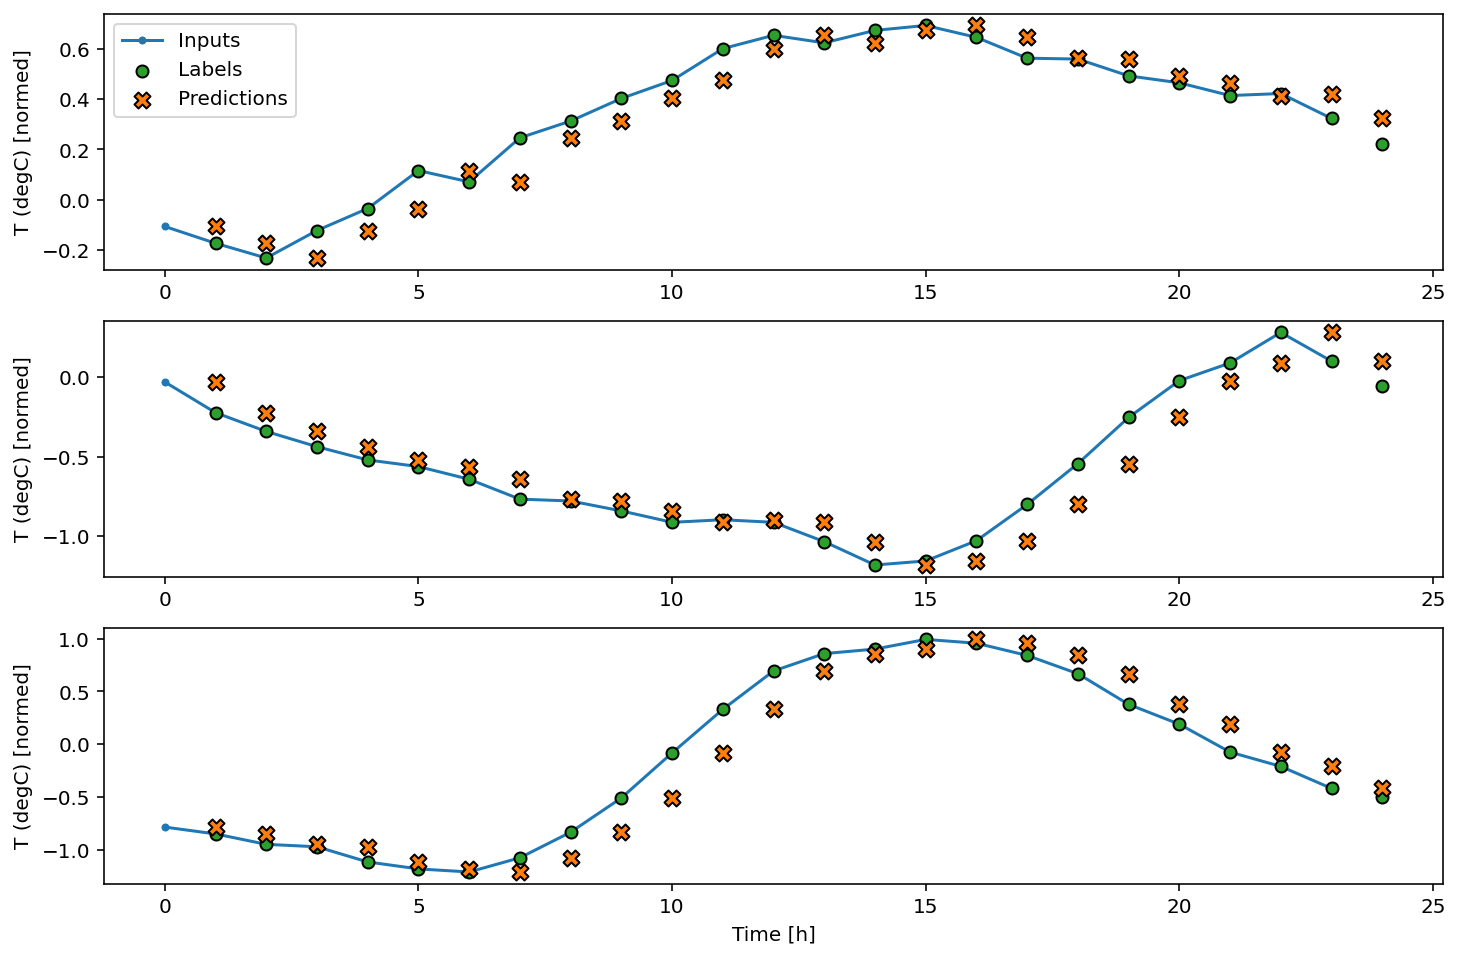

In [171]:
wide_window.plot(baseline)
# save_fig('baseline_plot.png')

In [172]:
class Linear(Model):
    def __init__(self, in_features, out_features):
        super(Linear, self).__init__()
        self.layer = nn.Linear(in_features, out_features)
    
    def forward(self, inputs):
        return self.layer(inputs)

In [173]:
linear = Linear(num_features, 1)
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: torch.Size([32, 1, 19])
Output shape: torch.Size([32, 1, 1])


In [259]:
def compile_and_fit(model, window, max_epochs=20, patience=2):
    model.compile(
        loss_fn=nn.MSELoss(),
        metric_fn=nn.L1Loss(),
        optimizer=optim.Adam(model.parameters())
    )
    early_stopping = EarlyStopping(patience=patience)

    for t in range(max_epochs):
        loss, metric = model.train_epoch(window.train)
        val_loss, val_metric = model.evaluate(window.val)
        info = ' - '.join([
            f'[Epoch {t + 1}/{max_epochs}]',
            f'loss: {loss:.4f}',
            f'metric: {metric:.4f}',
            f'val_loss: {val_loss:.4f}',
            f'val_metric: {val_metric:.4f}'
        ])
        print(info)
        if early_stopping(val_loss):
            break

In [174]:
compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
test_performance['Linear'] = linear.evaluate(single_step_window.test)

[Epoch 1/20] - loss: 0.1688 - metric: 0.2229 - val_loss: 0.0176 - val_metric: 0.1021
[Epoch 2/20] - loss: 0.0151 - metric: 0.0901 - val_loss: 0.0098 - val_metric: 0.0734
[Epoch 3/20] - loss: 0.0096 - metric: 0.0718 - val_loss: 0.0089 - val_metric: 0.0701
[Epoch 4/20] - loss: 0.0092 - metric: 0.0704 - val_loss: 0.0089 - val_metric: 0.0703
[Epoch 5/20] - loss: 0.0092 - metric: 0.0704 - val_loss: 0.0088 - val_metric: 0.0690
[Epoch 6/20] - loss: 0.0092 - metric: 0.0702 - val_loss: 0.0090 - val_metric: 0.0711
[Epoch 7/20] - loss: 0.0091 - metric: 0.0700 - val_loss: 0.0088 - val_metric: 0.0696


In [175]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: torch.Size([32, 24, 19])
Output shape: torch.Size([32, 24, 1])


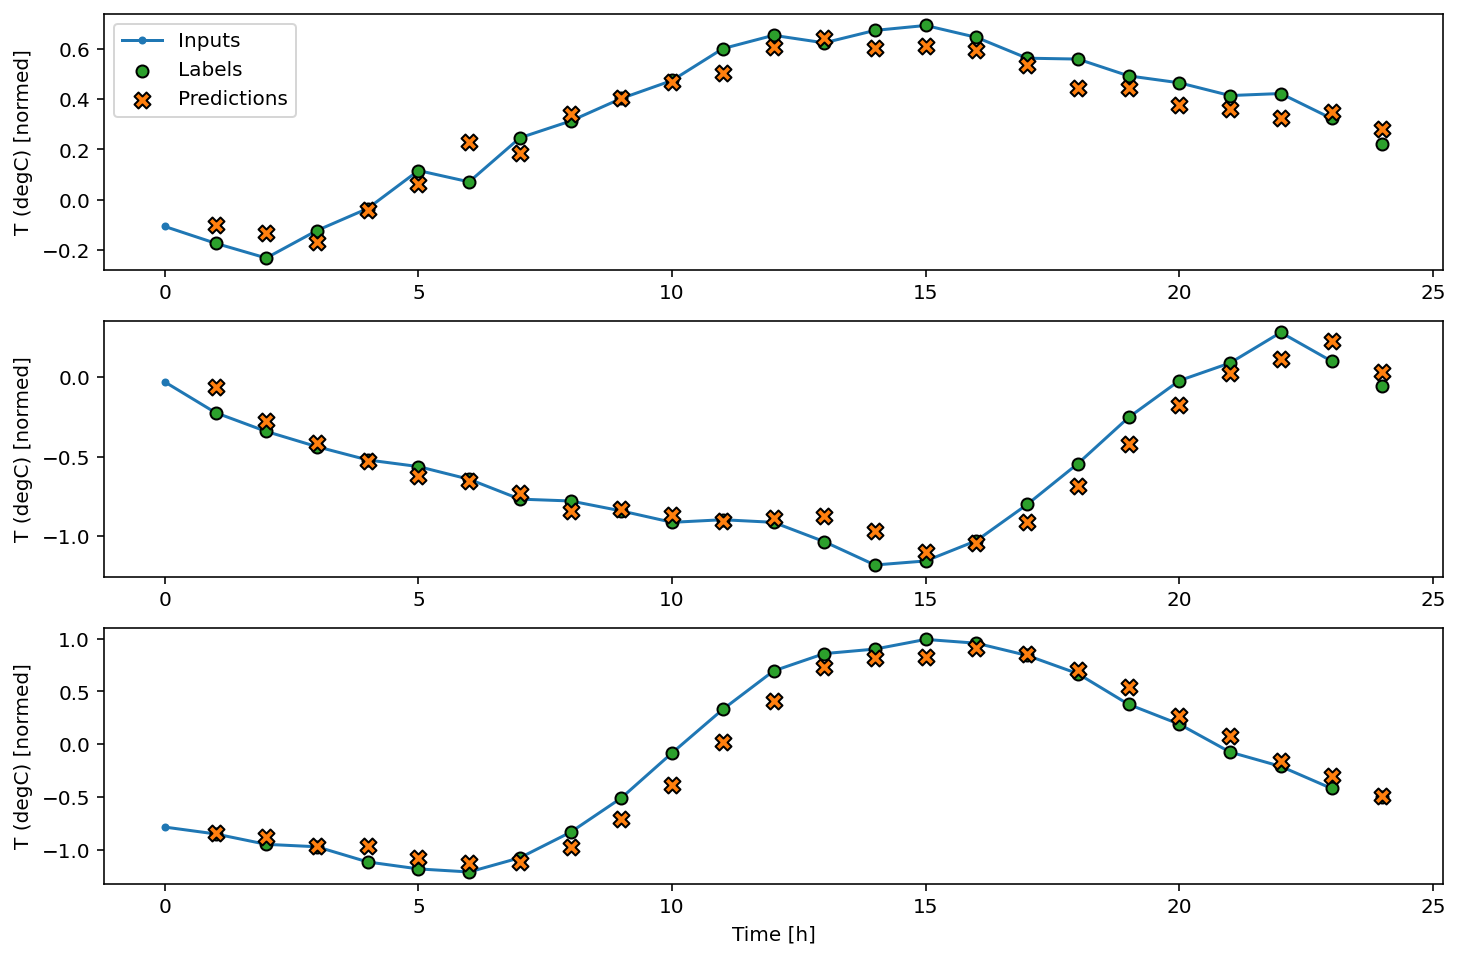

In [176]:
wide_window.plot(linear)
# save_fig('linear_plot.png')

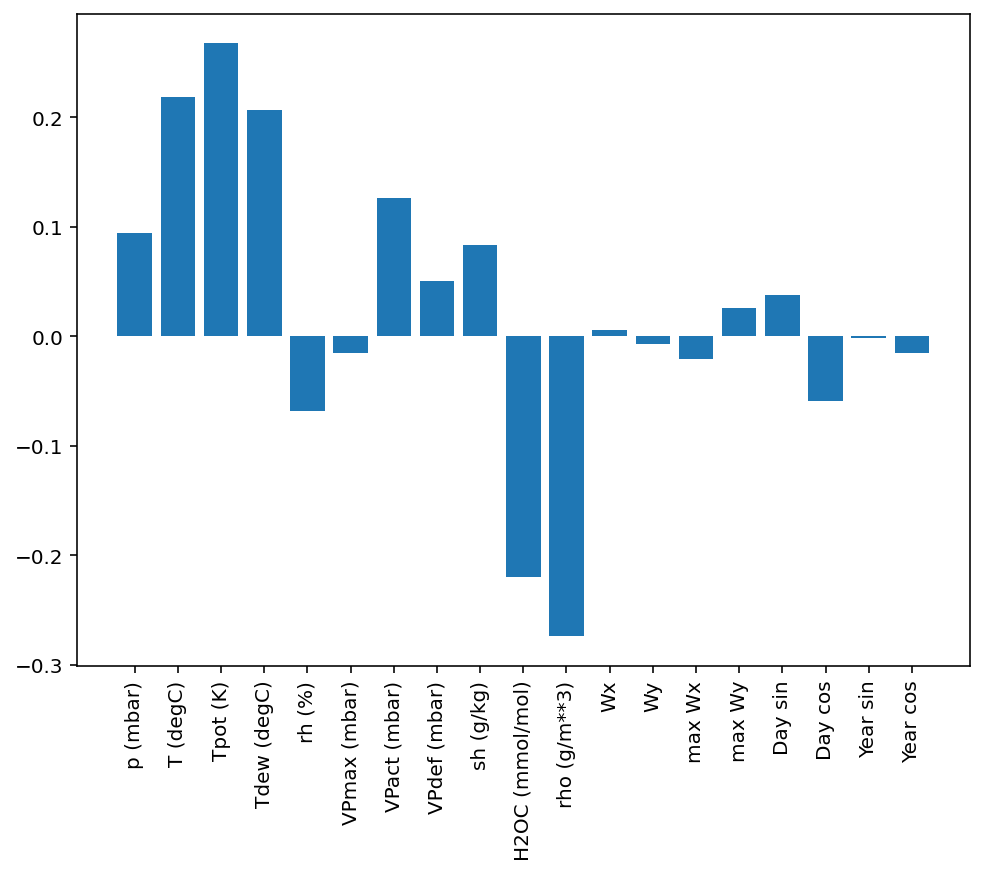

In [180]:
x = np.arange(num_features)
_, ax = plt.subplots()
ax.bar(x, tensor_to_numpy(linear.layer.weight[0, :]))
ax.set_xticks(x)
ax.set_xticklabels(train_df.columns, rotation=90)
# save_fig('linear_weight.png')

In [181]:
class Dense(Model):
    def __init__(self, in_features, out_features):
        super(Dense, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, out_features)
        )
    
    def forward(self, x):
        return self.layers(x)

dense = Dense(num_features, 1)
compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
test_performance['Dense'] = dense.evaluate(single_step_window.test)

[Epoch 1/20] - loss: 0.0189 - metric: 0.0783 - val_loss: 0.0074 - val_metric: 0.0624
[Epoch 2/20] - loss: 0.0076 - metric: 0.0625 - val_loss: 0.0074 - val_metric: 0.0636
[Epoch 3/20] - loss: 0.0072 - metric: 0.0606 - val_loss: 0.0075 - val_metric: 0.0615


In [182]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)']
)
conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column names(s): ['T (degC)']

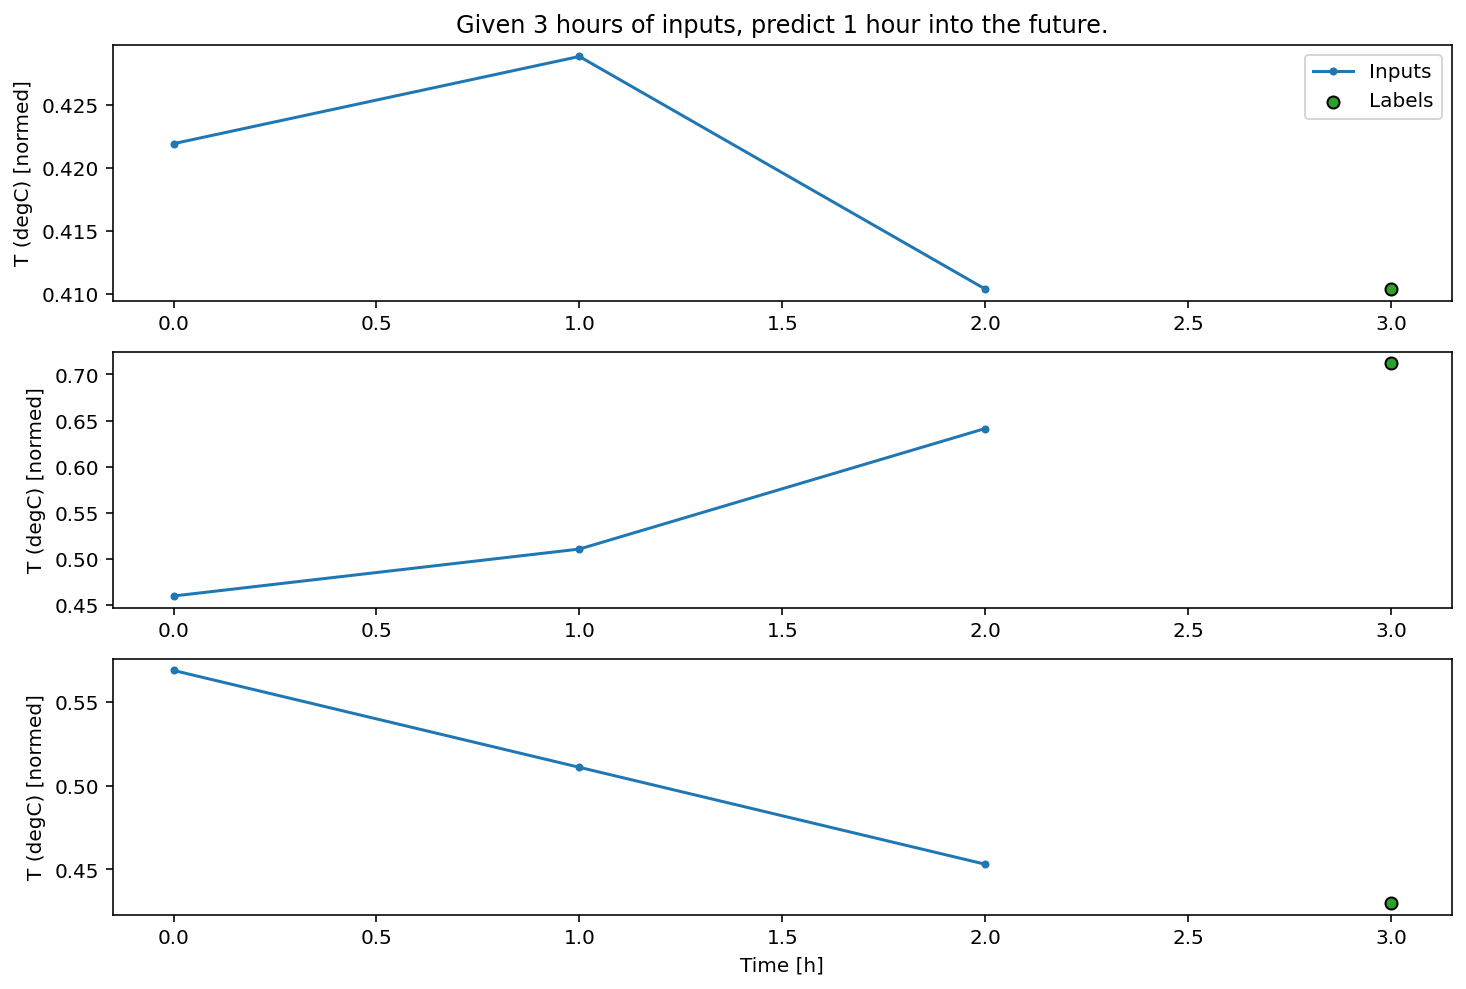

In [183]:
conv_window.plot()
ax = plt.gcf().axes[0]
ax.set_title('Given 3 hours of inputs, predict 1 hour into the future.')
# save_fig('conv_window_plot')

In [188]:
class nnReshape(nn.Module):
    def __init__(self, *shape):
        super(nnReshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.reshape(self.shape)

class MultiStepDense(Model):
    def __init__(self, in_features, out_features):
        super(MultiStepDense, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(CONV_WIDTH * in_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, out_features),
            nnReshape(-1, 1, out_features)
        )
    
    def forward(self, x):
        return self.layers(x)

In [197]:
multi_step_dense = MultiStepDense(num_features, 1)
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: torch.Size([32, 3, 19])
Output shape: torch.Size([32, 1, 1])


In [198]:
compile_and_fit(multi_step_dense, conv_window)
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
test_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test)

[Epoch 1/20] - loss: 0.0270 - metric: 0.0899 - val_loss: 0.0070 - val_metric: 0.0598
[Epoch 2/20] - loss: 0.0073 - metric: 0.0609 - val_loss: 0.0066 - val_metric: 0.0583
[Epoch 3/20] - loss: 0.0070 - metric: 0.0596 - val_loss: 0.0062 - val_metric: 0.0552
[Epoch 4/20] - loss: 0.0068 - metric: 0.0585 - val_loss: 0.0076 - val_metric: 0.0619
[Epoch 5/20] - loss: 0.0066 - metric: 0.0577 - val_loss: 0.0067 - val_metric: 0.0580


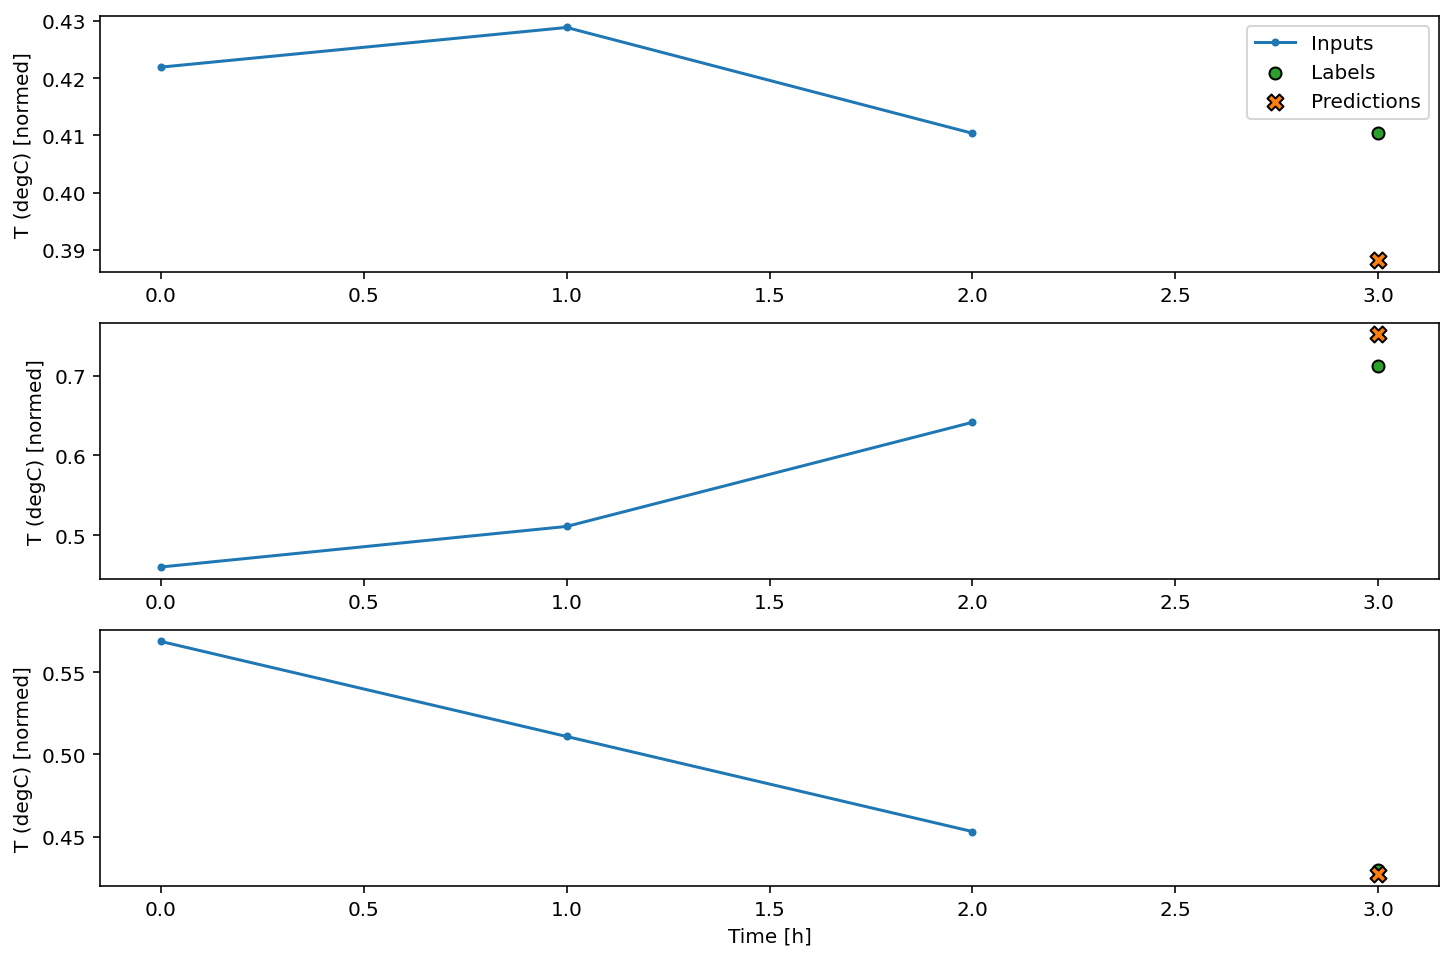

In [200]:
conv_window.plot(multi_step_dense)
# save_fig('multistepdense_plot.png')

In [201]:
print('Input shape:', wide_window.example[0].shape)
try:
    print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f'\n{type(e).__name__}:{e}')

Input shape: torch.Size([32, 24, 19])

RuntimeError:mat1 and mat2 shapes cannot be multiplied (32x456 and 57x32)


In [202]:
class nnTranspose(nn.Module):
    def __init__(self, dim0, dim1):
        super(nnTranspose, self).__init__()
        self.dim0 = dim0
        self.dim1 = dim1

    def forward(self, x):
        return x.transpose(self.dim0, self.dim1)

class ConvModel(Model):
    def __init__(self, in_features, out_features):
        super(ConvModel, self).__init__()
        self.layers = nn.Sequential(
            nnTranspose(1, 2),
            nn.Conv1d(in_features, 32, CONV_WIDTH),
            nnTranspose(1, 2),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, out_features)
        )
    
    def forward(self, x):
        return self.layers(x)

In [203]:
conv_model = ConvModel(num_features, 1)
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Input shape: torch.Size([32, 3, 19])
Output shape: torch.Size([32, 1, 1])


In [204]:
compile_and_fit(conv_model, conv_window)
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
test_performance['Conv'] = conv_model.evaluate(conv_window.test)

[Epoch 1/20] - loss: 0.0158 - metric: 0.0789 - val_loss: 0.0081 - val_metric: 0.0667
[Epoch 2/20] - loss: 0.0075 - metric: 0.0618 - val_loss: 0.0081 - val_metric: 0.0676
[Epoch 3/20] - loss: 0.0073 - metric: 0.0608 - val_loss: 0.0068 - val_metric: 0.0596
[Epoch 4/20] - loss: 0.0070 - metric: 0.0594 - val_loss: 0.0068 - val_metric: 0.0589
[Epoch 5/20] - loss: 0.0070 - metric: 0.0593 - val_loss: 0.0061 - val_metric: 0.0547
[Epoch 6/20] - loss: 0.0068 - metric: 0.0583 - val_loss: 0.0062 - val_metric: 0.0551
[Epoch 7/20] - loss: 0.0067 - metric: 0.0579 - val_loss: 0.0072 - val_metric: 0.0617


In [205]:
print('Wide window')
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: torch.Size([32, 24, 19])
Labels shape: torch.Size([32, 24, 1])
Output shape: torch.Size([32, 22, 1])


In [206]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)']
)
wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column names(s): ['T (degC)']

In [207]:
print('Wide conv window')
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: torch.Size([32, 26, 19])
Labels shape: torch.Size([32, 24, 1])
Output shape: torch.Size([32, 24, 1])


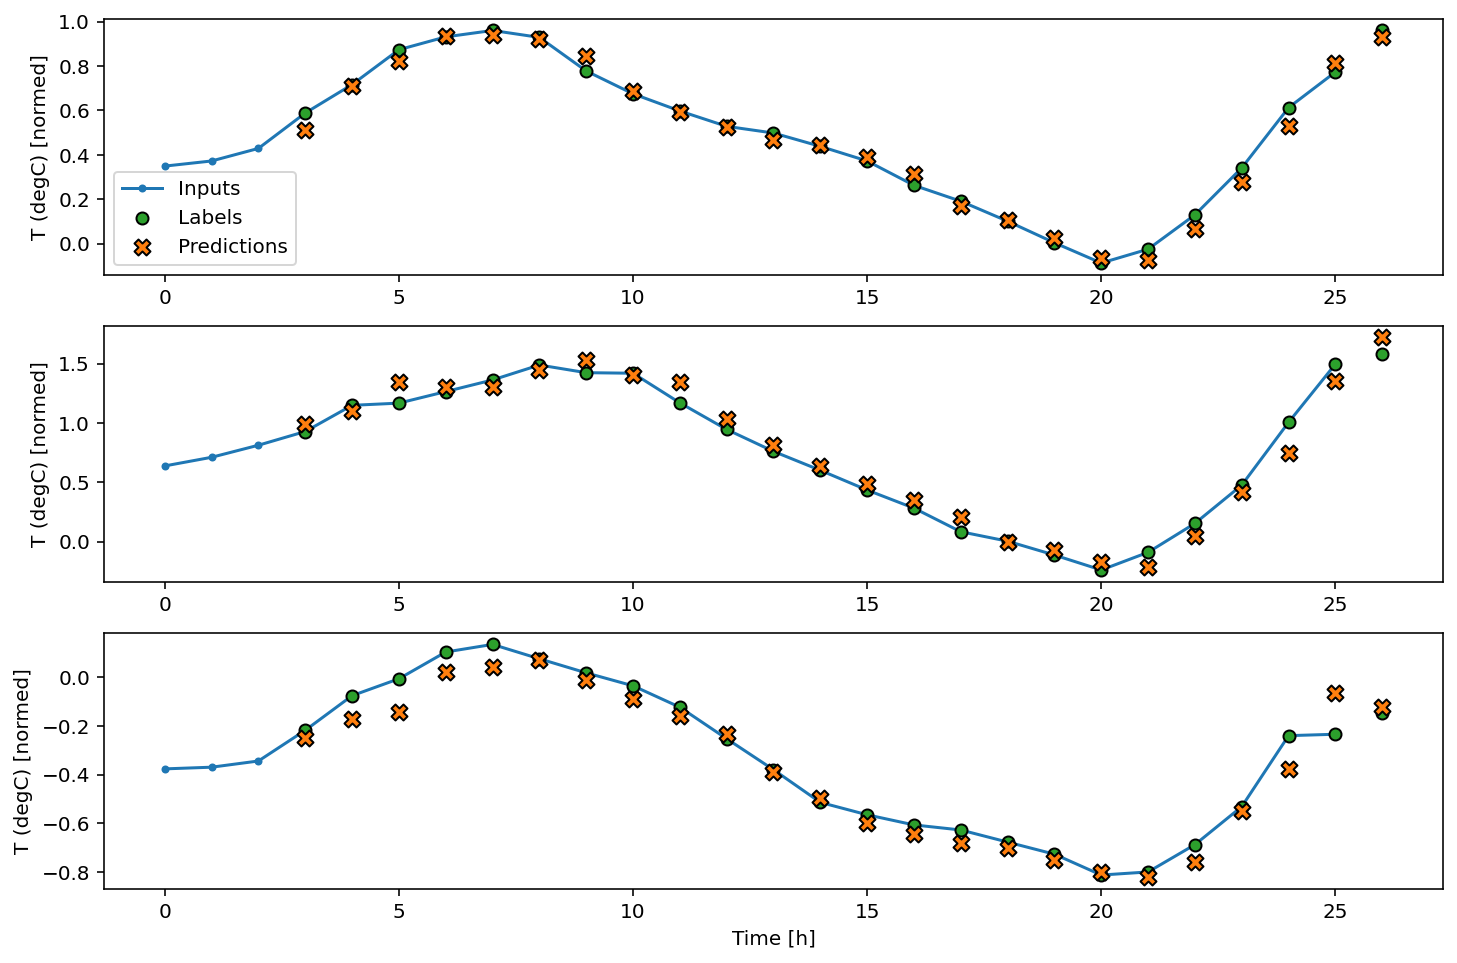

In [209]:
wide_conv_window.plot(conv_model)
# save_fig('convmodel_plot.png')

In [210]:
class LstmModel(Model):
    def __init__(self, in_features, out_features):
        super(LstmModel, self).__init__()
        self.lstm = nn.LSTM(in_features, 32, batch_first=True)
        self.linear = nn.Linear(32, out_features)
    
    def forward(self, x):
        output, _ = self.lstm(x)
        return self.linear(output)

In [211]:
lstm_model = LstmModel(num_features, 1)
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: torch.Size([32, 24, 19])
Output shape: torch.Size([32, 24, 1])


In [212]:
compile_and_fit(lstm_model, wide_window)
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
test_performance['LSTM'] = lstm_model.evaluate(wide_window.test)

[Epoch 1/20] - loss: 0.0311 - metric: 0.0900 - val_loss: 0.0063 - val_metric: 0.0552
[Epoch 2/20] - loss: 0.0063 - metric: 0.0548 - val_loss: 0.0058 - val_metric: 0.0526
[Epoch 3/20] - loss: 0.0059 - metric: 0.0529 - val_loss: 0.0056 - val_metric: 0.0517
[Epoch 4/20] - loss: 0.0057 - metric: 0.0521 - val_loss: 0.0056 - val_metric: 0.0513
[Epoch 5/20] - loss: 0.0056 - metric: 0.0514 - val_loss: 0.0055 - val_metric: 0.0508
[Epoch 6/20] - loss: 0.0055 - metric: 0.0510 - val_loss: 0.0055 - val_metric: 0.0512
[Epoch 7/20] - loss: 0.0054 - metric: 0.0505 - val_loss: 0.0057 - val_metric: 0.0519


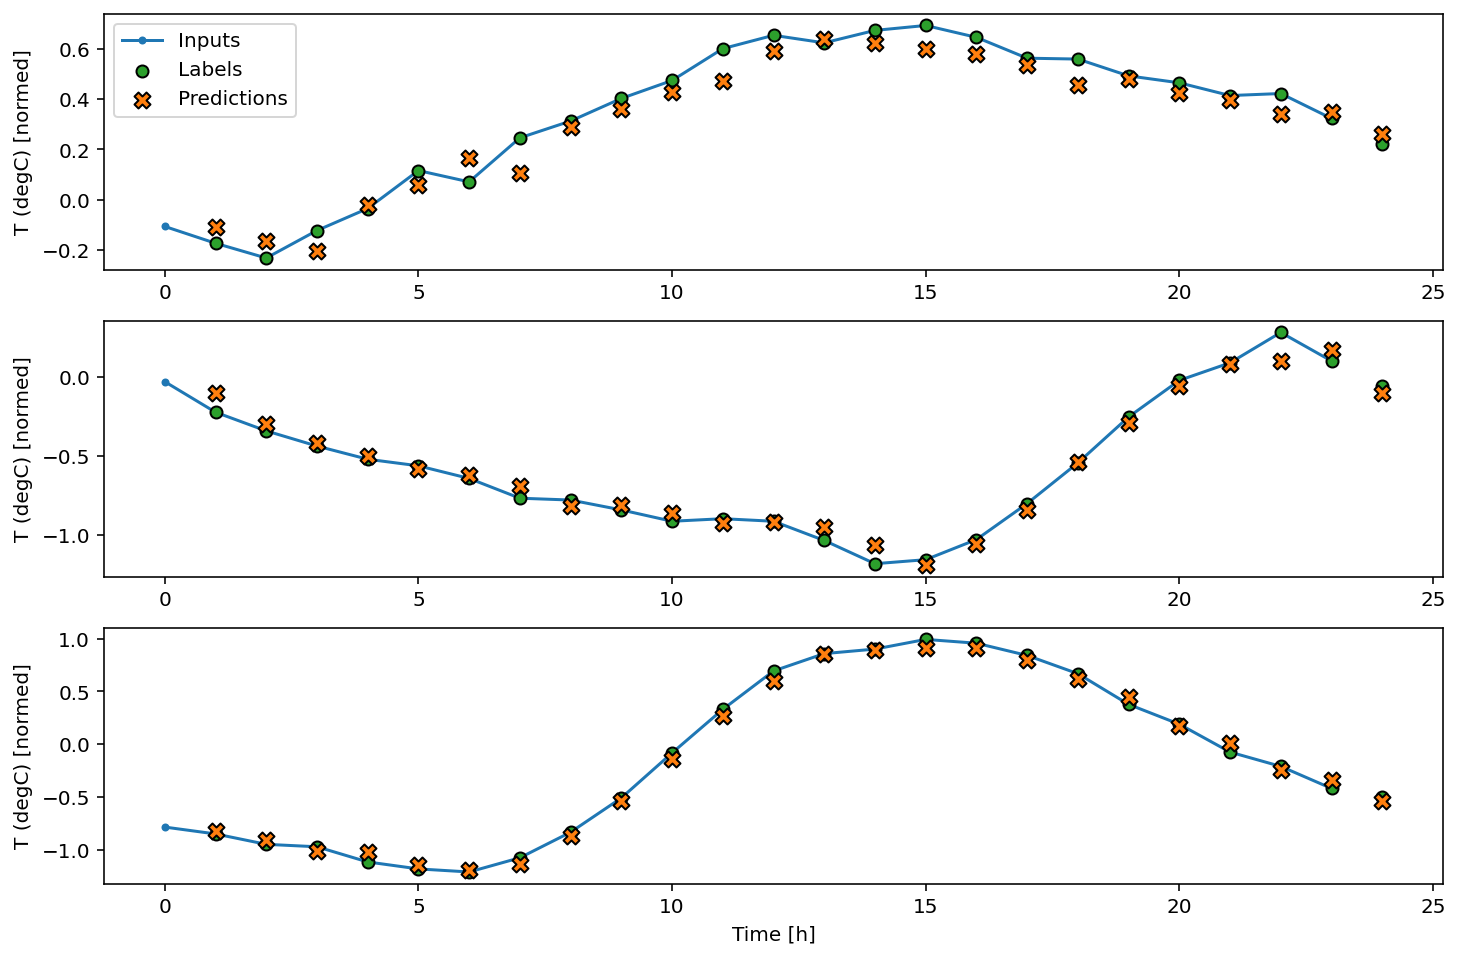

In [213]:
wide_window.plot(lstm_model)
# save_fig('lstmmodel_plot.png')

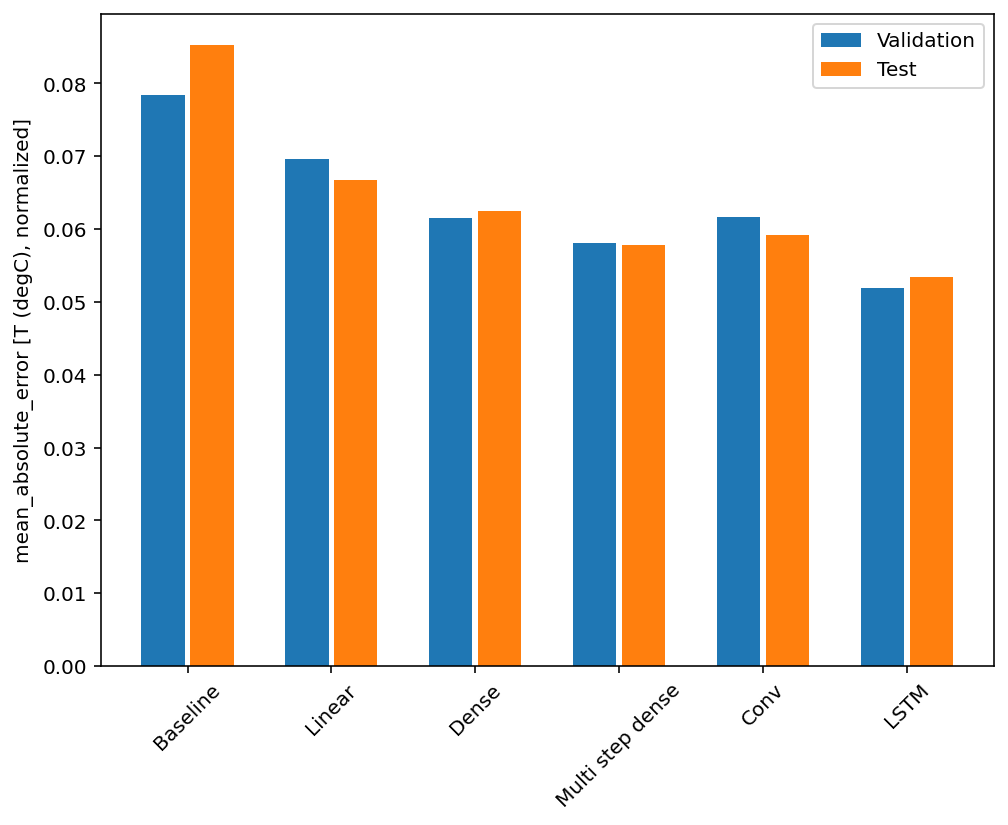

In [215]:
def plot_performance(val_performance, test_performance, ylabel):
    x = np.arange(len(val_performance))
    width = 0.3
    metric_index = 1
    val_mae = [v[metric_index] for v in val_performance.values()]
    test_mae = [v[metric_index] for v in test_performance.values()]

    plt.ylabel(ylabel)
    plt.bar(x - 0.17, val_mae, width, label='Validation')
    plt.bar(x + 0.17, test_mae, width, label='Test')
    plt.xticks(ticks=x, labels=val_performance.keys(), rotation=45)
    plt.legend()

plot_performance(
    val_performance, test_performance,
    ylabel='mean_absolute_error [T (degC), normalized]'
)
save_fig('single_step_performance.png')

In [218]:
for name, value in test_performance.items():
    print(f'{name:18s}: {value[1]:0.4f}')

Baseline          : 0.0853
Linear            : 0.0668
Dense             : 0.0625
Multi step dense  : 0.0578
Conv              : 0.0592
LSTM              : 0.0534


In [219]:
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1)
wide_window = WindowGenerator(input_width=24, label_width=24, shift=1)

example_inputs, example_labels = wide_window.example
print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): torch.Size([32, 24, 19])
Labels shape (batch, time, features): torch.Size([32, 24, 19])


In [220]:
baseline = Baseline()
baseline.compile(loss_fn=nn.MSELoss(), metric_fn=nn.L1Loss())

In [222]:
val_performance = {}
test_performance = {}
loss, metric = baseline.evaluate(single_step_window.val)
print(f'loss: {loss:.4f} - metric: {metric:.4f}')

val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
test_performance['Baseline'] = baseline.evaluate(single_step_window.test)

loss: 0.0892 - metric: 0.1593


In [223]:
dense = Dense(num_features, num_features)
compile_and_fit(dense, single_step_window)
val_performance['Dense'] = dense.evaluate(single_step_window.val)
test_performance['Dense'] = dense.evaluate(single_step_window.test)

[Epoch 1/20] - loss: 0.1069 - metric: 0.1845 - val_loss: 0.0726 - val_metric: 0.1448
[Epoch 2/20] - loss: 0.0724 - metric: 0.1430 - val_loss: 0.0717 - val_metric: 0.1405
[Epoch 3/20] - loss: 0.0711 - metric: 0.1394 - val_loss: 0.0705 - val_metric: 0.1382
[Epoch 4/20] - loss: 0.0703 - metric: 0.1370 - val_loss: 0.0710 - val_metric: 0.1383
[Epoch 5/20] - loss: 0.0699 - metric: 0.1355 - val_loss: 0.0698 - val_metric: 0.1342
[Epoch 6/20] - loss: 0.0692 - metric: 0.1335 - val_loss: 0.0690 - val_metric: 0.1328
[Epoch 7/20] - loss: 0.0689 - metric: 0.1326 - val_loss: 0.0681 - val_metric: 0.1307
[Epoch 8/20] - loss: 0.0686 - metric: 0.1315 - val_loss: 0.0687 - val_metric: 0.1314
[Epoch 9/20] - loss: 0.0684 - metric: 0.1308 - val_loss: 0.0683 - val_metric: 0.1316


In [224]:
%%time
lstm_model = LstmModel(num_features, num_features)
compile_and_fit(lstm_model, wide_window)
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
test_performance['LSTM'] = lstm_model.evaluate(wide_window.test)

[Epoch 1/20] - loss: 0.1299 - metric: 0.2077 - val_loss: 0.0688 - val_metric: 0.1384
[Epoch 2/20] - loss: 0.0662 - metric: 0.1318 - val_loss: 0.0643 - val_metric: 0.1277
[Epoch 3/20] - loss: 0.0638 - metric: 0.1262 - val_loss: 0.0633 - val_metric: 0.1253
[Epoch 4/20] - loss: 0.0628 - metric: 0.1240 - val_loss: 0.0627 - val_metric: 0.1234
[Epoch 5/20] - loss: 0.0622 - metric: 0.1227 - val_loss: 0.0624 - val_metric: 0.1227
[Epoch 6/20] - loss: 0.0618 - metric: 0.1218 - val_loss: 0.0623 - val_metric: 0.1225
[Epoch 7/20] - loss: 0.0615 - metric: 0.1213 - val_loss: 0.0624 - val_metric: 0.1218
[Epoch 8/20] - loss: 0.0613 - metric: 0.1209 - val_loss: 0.0625 - val_metric: 0.1217
CPU times: total: 12.7 s
Wall time: 2min 23s


In [225]:
class ResidualWrapper(Model):
    def __init__(self, model):
        super(ResidualWrapper, self).__init__()
        self.model = model
    
    def forward(self, x):
        dx = self.model(x)
        return x + dx

In [226]:
%%time
lstm_model = LstmModel(num_features, num_features)
nn.init.zeros_(lstm_model.linear.weight) # 直接修改参数的话需要用no_grad包裹.
residual_lstm = ResidualWrapper(lstm_model)

compile_and_fit(residual_lstm, wide_window)
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
test_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test)

[Epoch 1/20] - loss: 0.0658 - metric: 0.1238 - val_loss: 0.0631 - val_metric: 0.1193
[Epoch 2/20] - loss: 0.0620 - metric: 0.1181 - val_loss: 0.0624 - val_metric: 0.1182
[Epoch 3/20] - loss: 0.0609 - metric: 0.1169 - val_loss: 0.0622 - val_metric: 0.1178
[Epoch 4/20] - loss: 0.0603 - metric: 0.1163 - val_loss: 0.0619 - val_metric: 0.1174
[Epoch 5/20] - loss: 0.0598 - metric: 0.1159 - val_loss: 0.0619 - val_metric: 0.1173
[Epoch 6/20] - loss: 0.0593 - metric: 0.1155 - val_loss: 0.0623 - val_metric: 0.1175
CPU times: total: 15.4 s
Wall time: 1min 55s


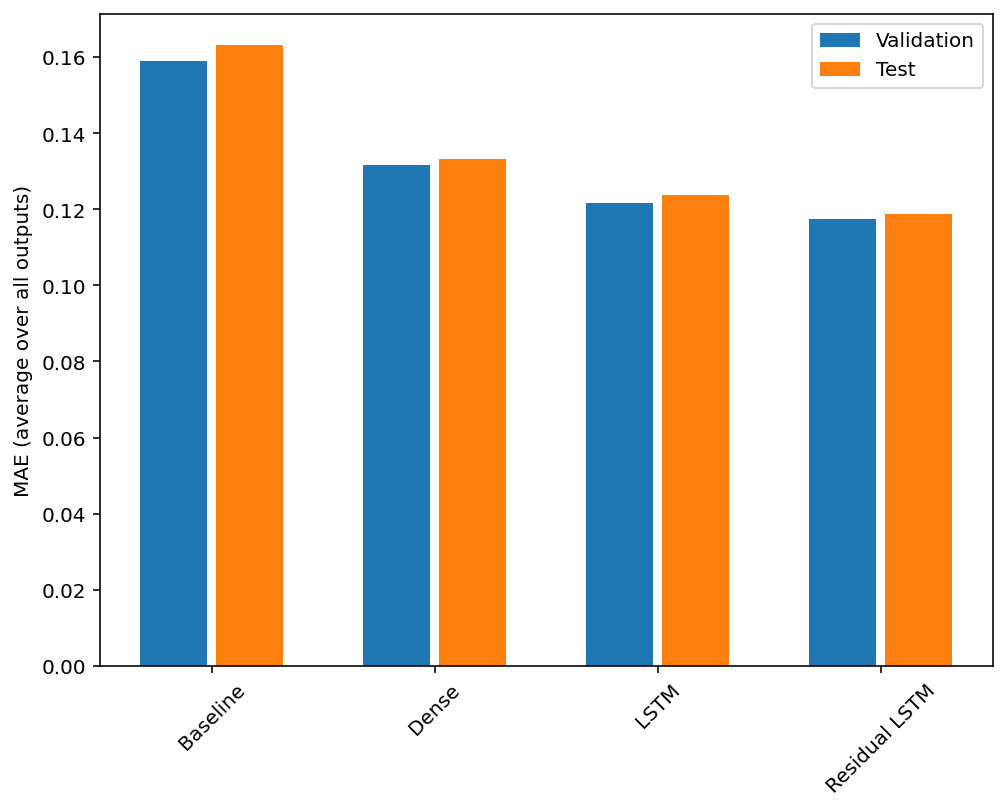

In [228]:
plot_performance(
    val_performance, test_performance,
    ylabel='MAE (average over all outputs)'
)
save_fig('multi_output_performance.png')

In [229]:
for name, value in test_performance.items():
    print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1633
Dense          : 0.1332
LSTM           : 0.1237
Residual LSTM  : 0.1188


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column names(s): ['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'Wx', 'Wy', 'max Wx', 'max Wy', 'Day sin', 'Day cos', 'Year sin', 'Year cos']

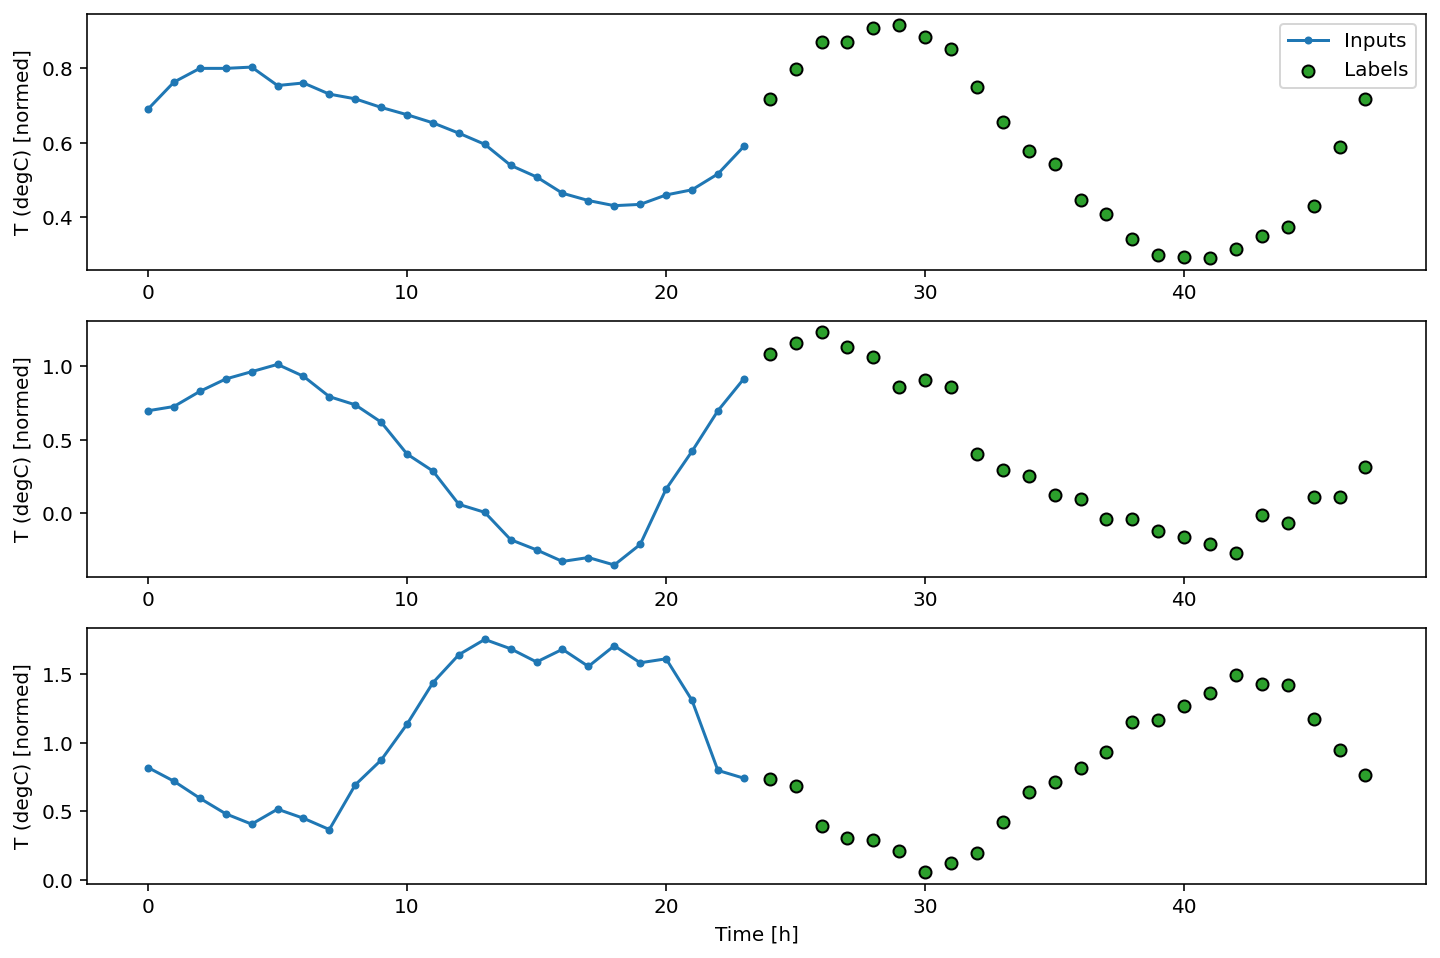

In [234]:
OUT_STEPS = 24
multi_window = WindowGenerator(
    input_width=24,
    label_width=OUT_STEPS,
    shift=OUT_STEPS
)
multi_window.plot()
multi_window
# save_fig('multi_window_plot.png')

loss: 0.6286 - metric: 0.5007


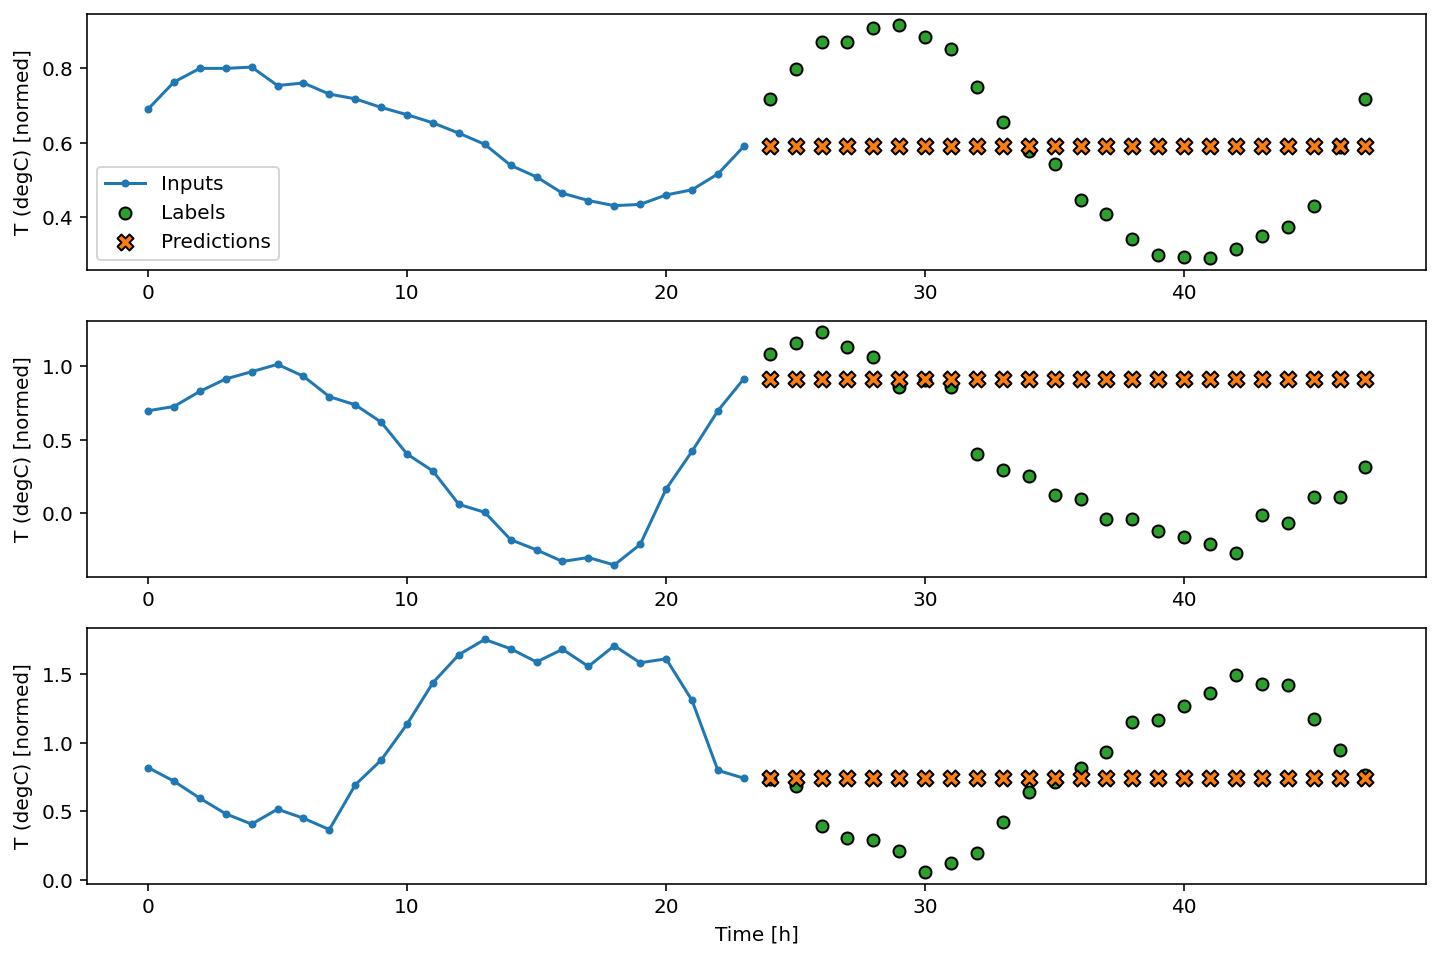

In [242]:
class MultiStepLastBaseline(Model):
    def __init__(self):
        super(MultiStepLastBaseline, self).__init__()
    
    def forward(self, x):
        return x[:, -1:, :].tile(1, OUT_STEPS, 1)

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss_fn=nn.MSELoss(), metric_fn=nn.L1Loss())

multi_val_performance = {}
multi_test_performance = {}
loss, metric = last_baseline.evaluate(multi_window.val)
print(f'loss: {loss:.4f} - metric: {metric:.4f}')

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_test_performance['Last'] = last_baseline.evaluate(multi_window.test)
multi_window.plot(last_baseline)
# save_fig('multistepbaseline_plot.png')

loss: 0.4271 - metric: 0.3959


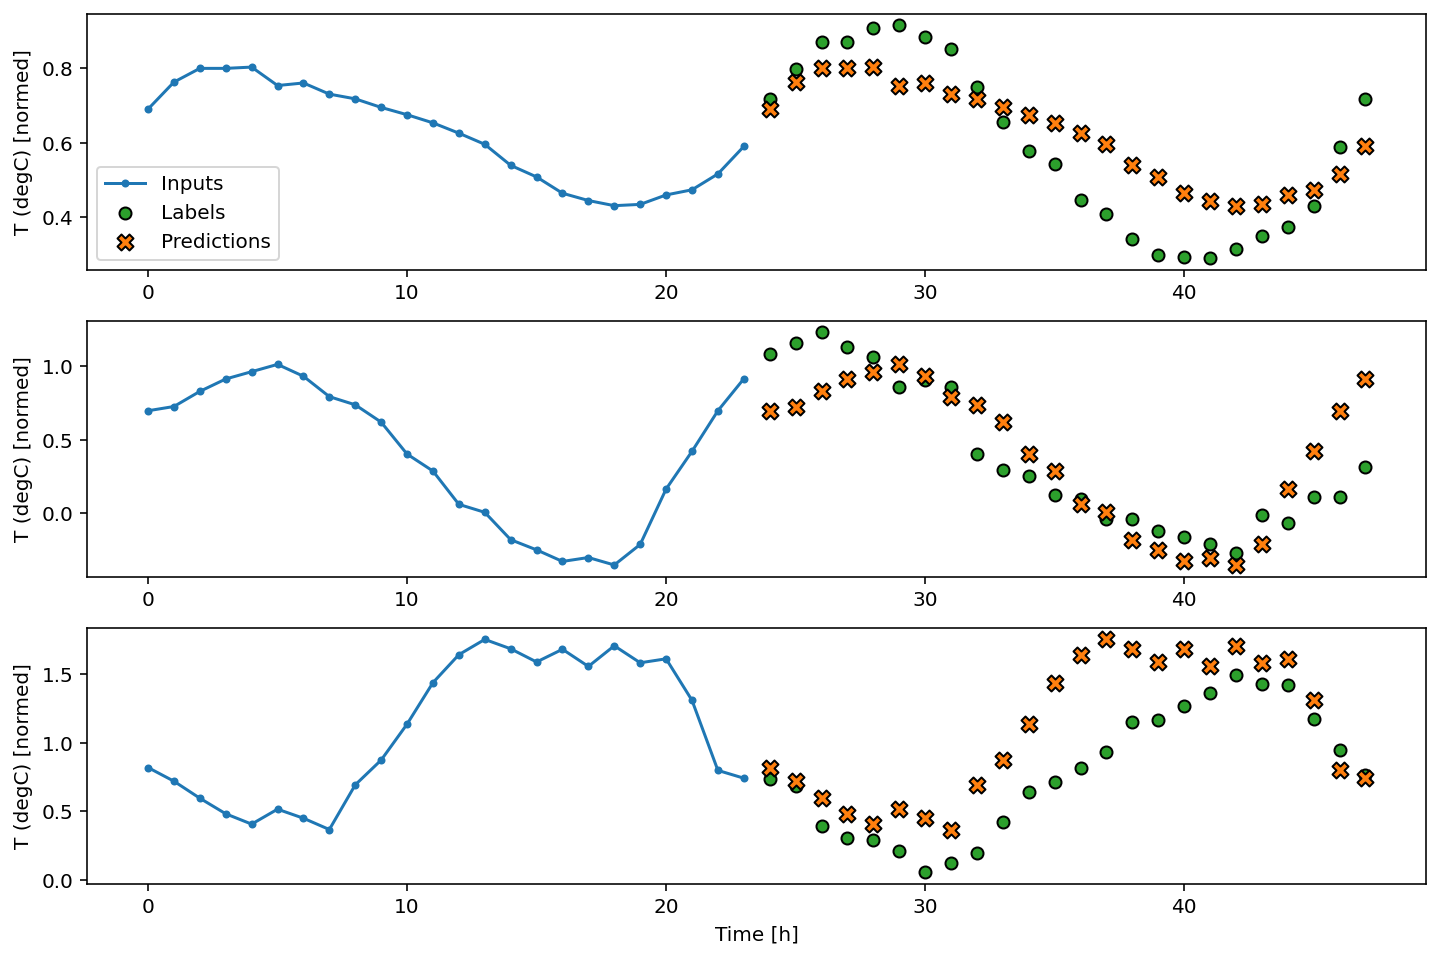

In [244]:
class RepeatBaseline(Model):
    def __init__(self):
        super(RepeatBaseline, self).__init__()
    
    def forward(self, x):
        return x

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss_fn=nn.MSELoss(), metric_fn=nn.L1Loss())
loss, metric = repeat_baseline.evaluate(multi_window.val)
print(f'loss: {loss:.4f} - metric: {metric:.4f}')

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_test_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test)
multi_window.plot(repeat_baseline)
# save_fig('repeatbaseline_plot.png')

[Epoch 1/20] - loss: 0.3296 - metric: 0.3990 - val_loss: 0.2585 - val_metric: 0.3232
[Epoch 2/20] - loss: 0.2570 - metric: 0.3127 - val_loss: 0.2558 - val_metric: 0.3059
[Epoch 3/20] - loss: 0.2562 - metric: 0.3074 - val_loss: 0.2559 - val_metric: 0.3055
[Epoch 4/20] - loss: 0.2561 - metric: 0.3072 - val_loss: 0.2550 - val_metric: 0.3049
[Epoch 5/20] - loss: 0.2560 - metric: 0.3071 - val_loss: 0.2558 - val_metric: 0.3052
[Epoch 6/20] - loss: 0.2560 - metric: 0.3071 - val_loss: 0.2555 - val_metric: 0.3050


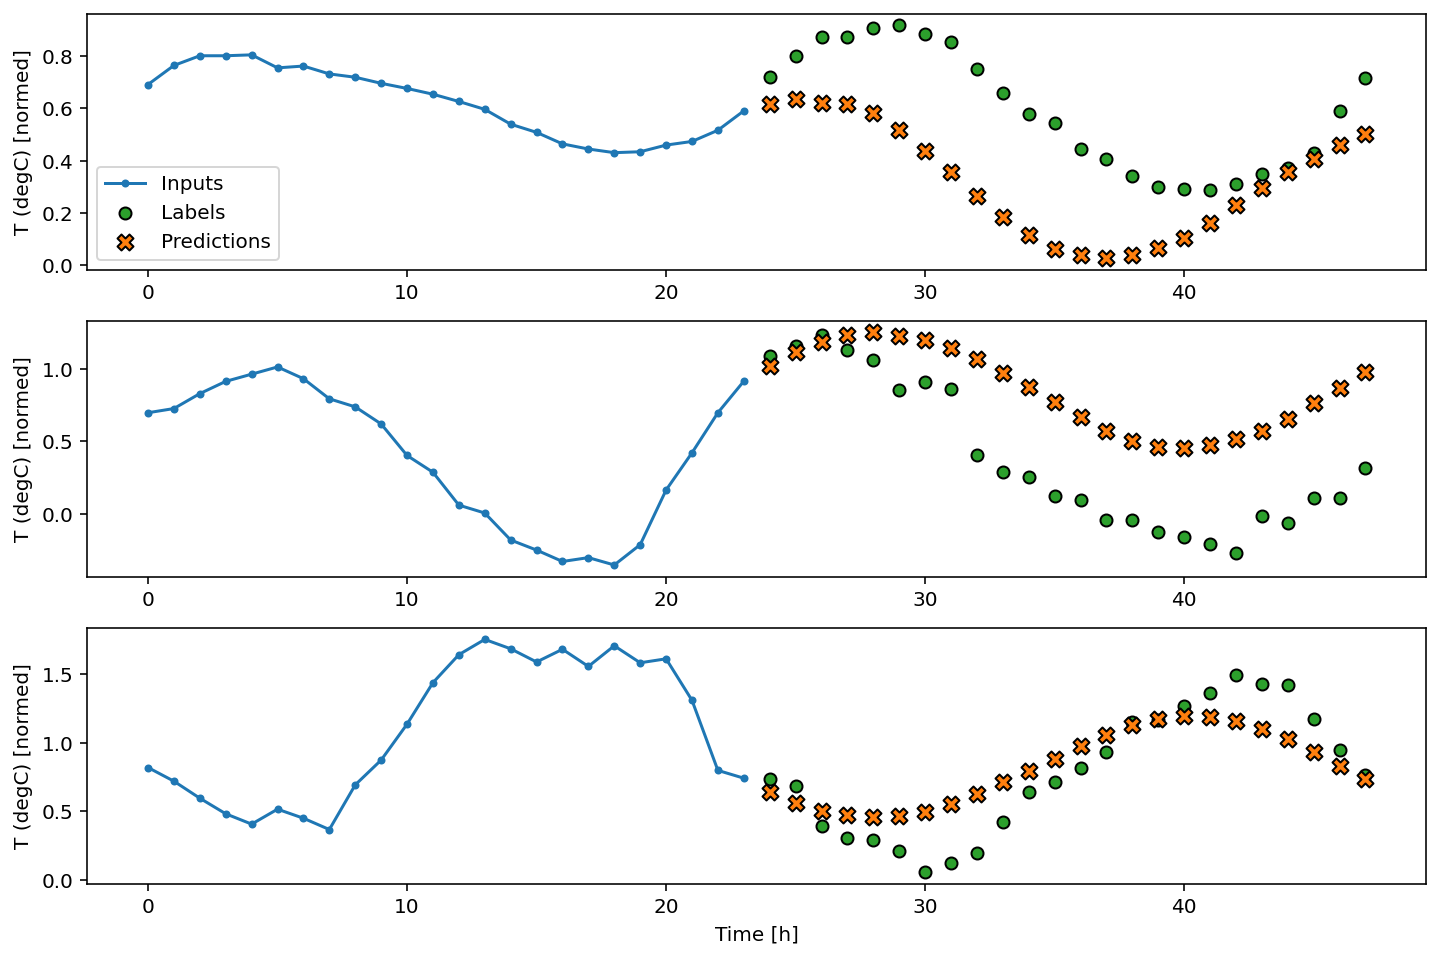

In [246]:
class MultiLinearModel(Model):
    def __init__(self, in_features, out_features):
        super(MultiLinearModel, self).__init__()
        self.layers = nn.Sequential(
            # Shape => [batch, 1, OUT_STEPS * features]
            nn.Linear(in_features, OUT_STEPS * out_features),
            # Shape => [batch, OUT_STEPS, features]
            nnReshape(-1, OUT_STEPS, out_features)
        )
        nn.init.zeros_(self.layers[0].weight)
    
    def forward(self, x):
        # Shape [batch, time, features] => [batch, 1, features]
        return self.layers(x[:, -1:, :])

multi_linear_model = MultiLinearModel(num_features, num_features)
compile_and_fit(multi_linear_model, multi_window)

multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_test_performance['Linear'] = multi_linear_model.evaluate(multi_window.test)
multi_window.plot(multi_linear_model)
# save_fig('multilinearmodel_plot.png')

[Epoch 1/20] - loss: 0.2346 - metric: 0.2957 - val_loss: 0.2249 - val_metric: 0.2854
[Epoch 2/20] - loss: 0.2204 - metric: 0.2826 - val_loss: 0.2217 - val_metric: 0.2845
[Epoch 3/20] - loss: 0.2169 - metric: 0.2798 - val_loss: 0.2208 - val_metric: 0.2835
[Epoch 4/20] - loss: 0.2146 - metric: 0.2781 - val_loss: 0.2179 - val_metric: 0.2806
[Epoch 5/20] - loss: 0.2130 - metric: 0.2771 - val_loss: 0.2194 - val_metric: 0.2824
[Epoch 6/20] - loss: 0.2118 - metric: 0.2763 - val_loss: 0.2194 - val_metric: 0.2809


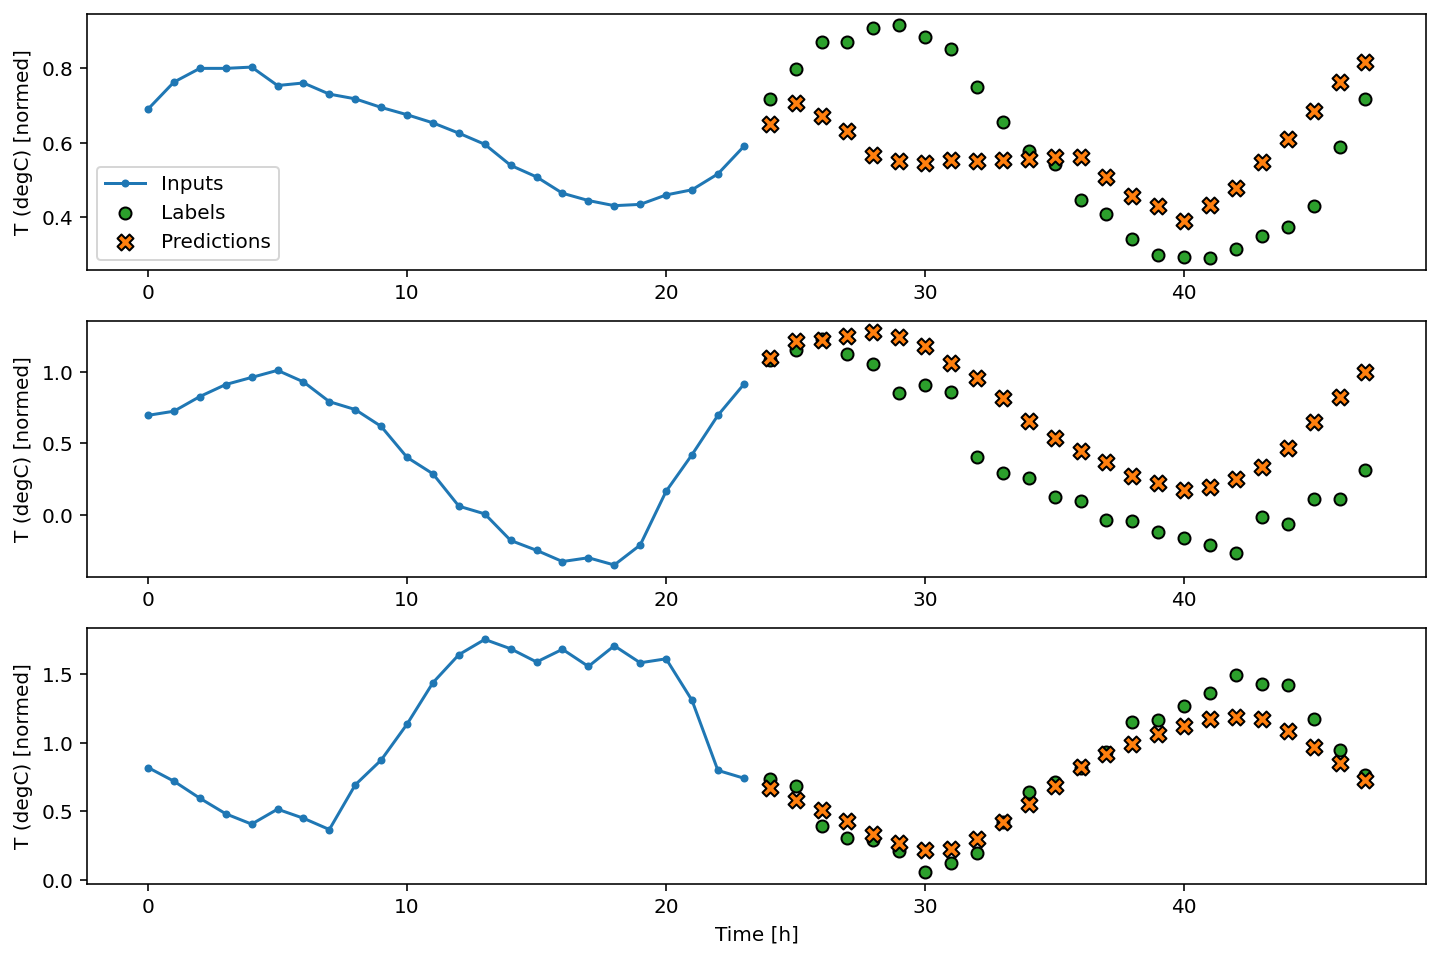

In [247]:
class MultiDenseModel(Model):
    def __init__(self, in_features, out_features):
        super(MultiDenseModel, self).__init__()
        self.dense = nn.Sequential(
            # Shape => [batch, 1, 512]
            nn.Linear(in_features, 512),
            nn.ReLU(),
            # Shape => [batch, 1, OUT_STEPS * features]
            nn.Linear(512, OUT_STEPS * out_features),
            # Shape => [batch, OUT_STEPS, features]
            nnReshape(-1, OUT_STEPS, out_features)
        )
        nn.init.zeros_(self.dense[2].weight)
    
    def forward(self, x):
        # Shape [batch, time, features] => [batch, 1, features]
        return self.dense(x[:, -1:, :])

multi_dense_model = MultiDenseModel(num_features, num_features)
compile_and_fit(multi_dense_model, multi_window)

multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_test_performance['Dense'] = multi_dense_model.evaluate(multi_window.test)
multi_window.plot(multi_dense_model)
# save_fig('multidensemodel_plot.png')

[Epoch 1/20] - loss: 0.2360 - metric: 0.3019 - val_loss: 0.2223 - val_metric: 0.2874
[Epoch 2/20] - loss: 0.2188 - metric: 0.2853 - val_loss: 0.2193 - val_metric: 0.2854
[Epoch 3/20] - loss: 0.2149 - metric: 0.2819 - val_loss: 0.2174 - val_metric: 0.2838
[Epoch 4/20] - loss: 0.2122 - metric: 0.2797 - val_loss: 0.2176 - val_metric: 0.2846
[Epoch 5/20] - loss: 0.2101 - metric: 0.2781 - val_loss: 0.2169 - val_metric: 0.2822
[Epoch 6/20] - loss: 0.2083 - metric: 0.2765 - val_loss: 0.2164 - val_metric: 0.2816
[Epoch 7/20] - loss: 0.2069 - metric: 0.2755 - val_loss: 0.2124 - val_metric: 0.2782
[Epoch 8/20] - loss: 0.2058 - metric: 0.2744 - val_loss: 0.2161 - val_metric: 0.2825
[Epoch 9/20] - loss: 0.2049 - metric: 0.2738 - val_loss: 0.2154 - val_metric: 0.2806


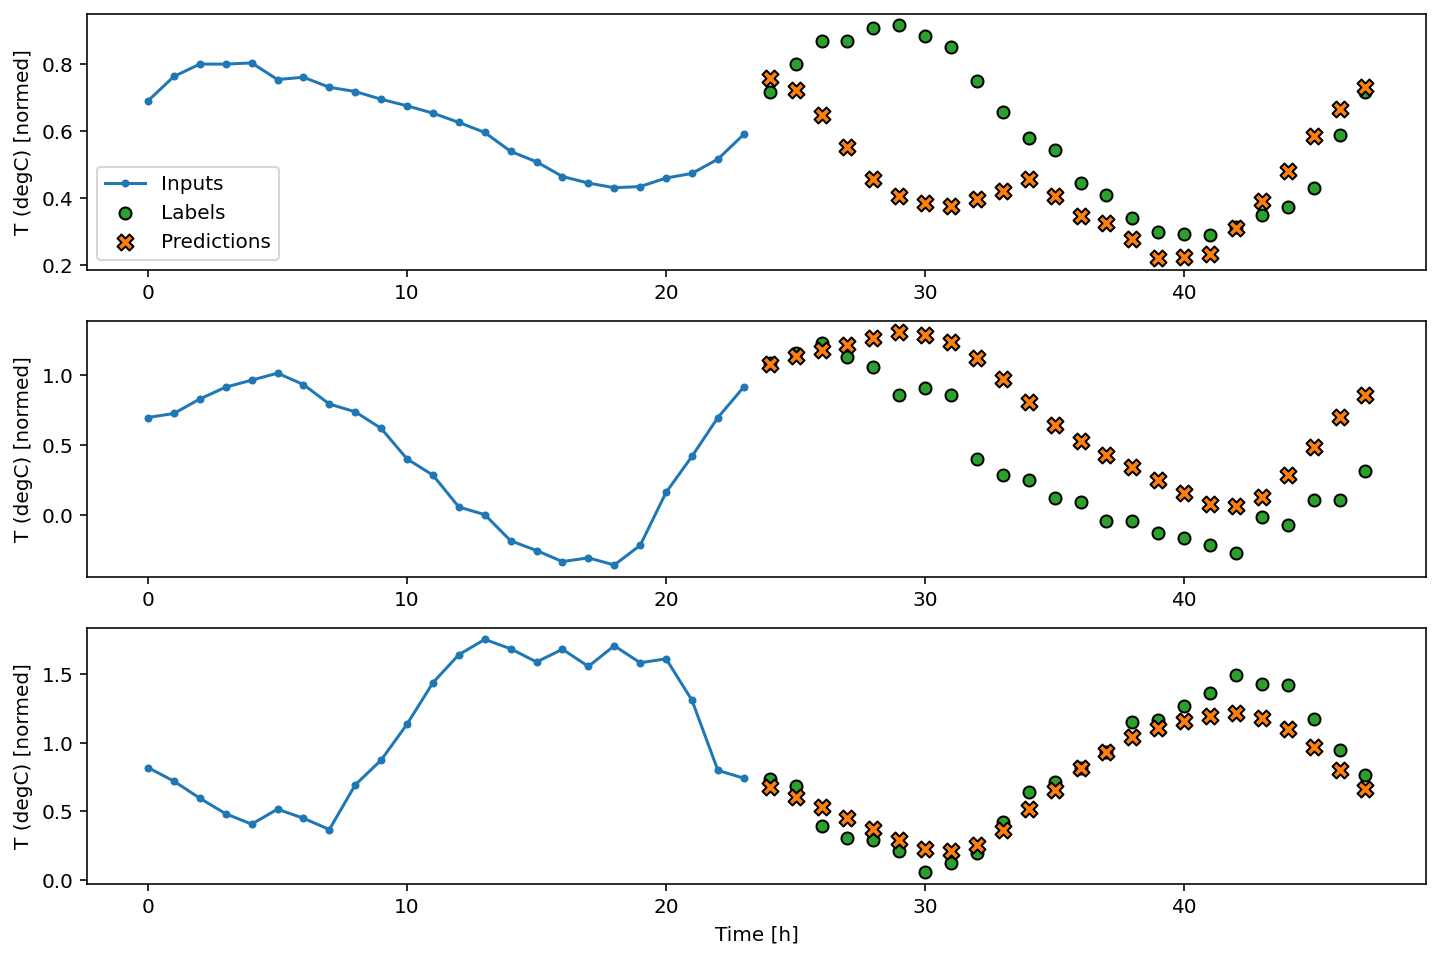

In [249]:
CONV_WIDTH = 3
class MultiConvModel(Model):
    def __init__(self, in_features, out_features):
        super(MultiConvModel, self).__init__()
        self.layers = nn.Sequential(
            # Shape => [batch, 1, 256]
            nnTranspose(1, 2),
            nn.Conv1d(in_features, 256, CONV_WIDTH),
            nnTranspose(1, 2),
            nn.ReLU(),
            # Shape => [batch, 1, OUTSTEPS * features]
            nn.Linear(256, OUT_STEPS * out_features),
            # Shape => [batch, OUTSTEPS, features]
            nnReshape(-1, OUT_STEPS, out_features)
        )
        nn.init.zeros_(self.layers[4].weight)

    def forward(self, x):
        # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
        return self.layers(x[:, -CONV_WIDTH:, :])

multi_conv_model = MultiConvModel(num_features, num_features)
compile_and_fit(multi_conv_model, multi_window)

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_test_performance['Conv'] = multi_conv_model.evaluate(multi_window.test)
multi_window.plot(multi_conv_model)
# save_fig('multiconvmodel_plot.png')

[Epoch 1/20] - loss: 0.2907 - metric: 0.3612 - val_loss: 0.2290 - val_metric: 0.3052
[Epoch 2/20] - loss: 0.2167 - metric: 0.2937 - val_loss: 0.2203 - val_metric: 0.2947
[Epoch 3/20] - loss: 0.2095 - metric: 0.2853 - val_loss: 0.2178 - val_metric: 0.2913
[Epoch 4/20] - loss: 0.2054 - metric: 0.2809 - val_loss: 0.2188 - val_metric: 0.2896
[Epoch 5/20] - loss: 0.2027 - metric: 0.2780 - val_loss: 0.2133 - val_metric: 0.2853
[Epoch 6/20] - loss: 0.2006 - metric: 0.2761 - val_loss: 0.2124 - val_metric: 0.2832
[Epoch 7/20] - loss: 0.1989 - metric: 0.2744 - val_loss: 0.2142 - val_metric: 0.2844
[Epoch 8/20] - loss: 0.1973 - metric: 0.2730 - val_loss: 0.2133 - val_metric: 0.2823


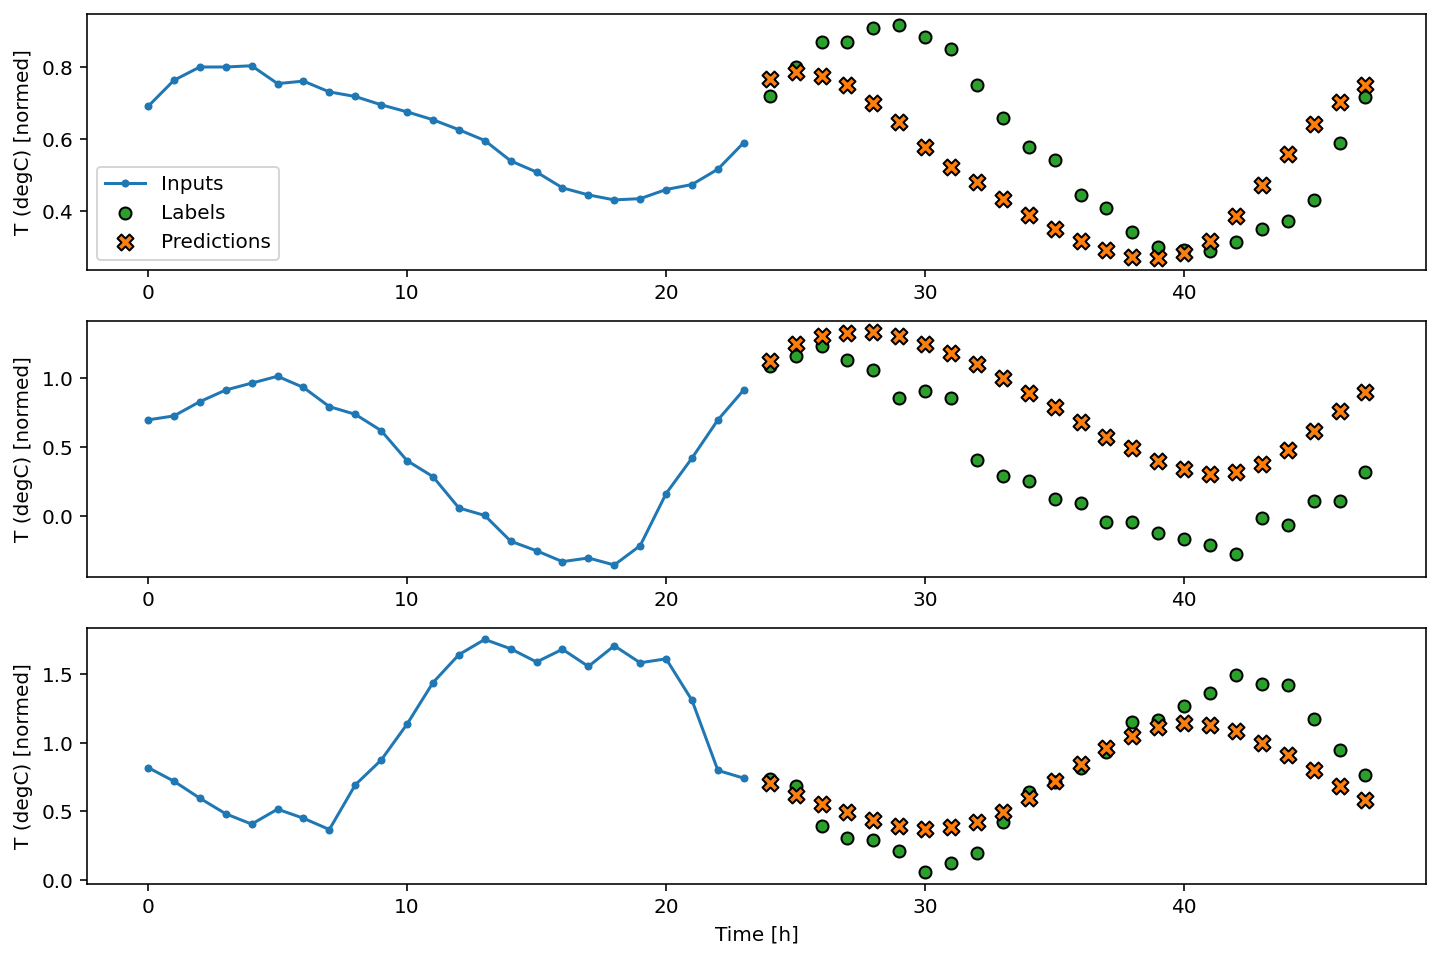

In [251]:
class MultiLstmModel(Model):
    def __init__(self, in_features, out_features):
        super(MultiLstmModel, self).__init__()
        self.lstm = nn.LSTM(in_features, 32, batch_first=True)
        self.linear = nn.Sequential(
            # Shape => [batch, 1, OUT_STEPS * features]
            nn.Linear(32, OUT_STEPS * out_features),
            # Shape => [batch, OUT_STEPS, features]
            nnReshape(-1, OUT_STEPS, out_features)
        )
        nn.init.zeros_(self.linear[0].weight)
    
    def forward(self, x):
        # Shape [batch, time, features] => [batch, time, 32]
        output, _ = self.lstm(x)
        # Shape => [batch, 1, 32]
        return self.linear(output[:, -1:, :])

multi_lstm_model = MultiLstmModel(num_features, num_features)
compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_test_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test)
multi_window.plot(multi_lstm_model)
# save_fig('multilstmmodel_plot.png')

In [253]:
class FeedBack(Model):
    def __init__(self, num_features, out_steps):
        super(FeedBack, self).__init__()
        self.out_steps = out_steps
        self.lstm = nn.LSTM(num_features, 32, batch_first=True)
        self.linear = nn.Linear(32, num_features)
    
    def next(self, x, hc=None):
        # Shape [batch, time, features] => [batch, 1, features]
        output, hc = self.lstm(x, hc)
        prediction = self.linear(output[:, -1:, :])
        return prediction, hc
    
    def forward(self, x):
        predictions = []
        prediction, hc = self.next(x)
        predictions.append(prediction)
        
        for i in range(1, self.out_steps):
            prediction, hc = self.next(prediction, hc)
            predictions.append(prediction)
        # Shape => [batch, out_steps, features]
        predictions = torch.cat(predictions, dim=1)
        
        return predictions

[Epoch 1/20] - loss: 0.3593 - metric: 0.4166 - val_loss: 0.2748 - val_metric: 0.3589
[Epoch 2/20] - loss: 0.2522 - metric: 0.3367 - val_loss: 0.2539 - val_metric: 0.3354
[Epoch 3/20] - loss: 0.2369 - metric: 0.3208 - val_loss: 0.2415 - val_metric: 0.3198
[Epoch 4/20] - loss: 0.2264 - metric: 0.3079 - val_loss: 0.2348 - val_metric: 0.3141
[Epoch 5/20] - loss: 0.2207 - metric: 0.3013 - val_loss: 0.2339 - val_metric: 0.3080
[Epoch 6/20] - loss: 0.2172 - metric: 0.2975 - val_loss: 0.2287 - val_metric: 0.3036
[Epoch 7/20] - loss: 0.2136 - metric: 0.2941 - val_loss: 0.2268 - val_metric: 0.3012
[Epoch 8/20] - loss: 0.2114 - metric: 0.2917 - val_loss: 0.2270 - val_metric: 0.3006
[Epoch 9/20] - loss: 0.2086 - metric: 0.2889 - val_loss: 0.2231 - val_metric: 0.2963
[Epoch 10/20] - loss: 0.2065 - metric: 0.2873 - val_loss: 0.2260 - val_metric: 0.3001
[Epoch 11/20] - loss: 0.2040 - metric: 0.2850 - val_loss: 0.2286 - val_metric: 0.3018


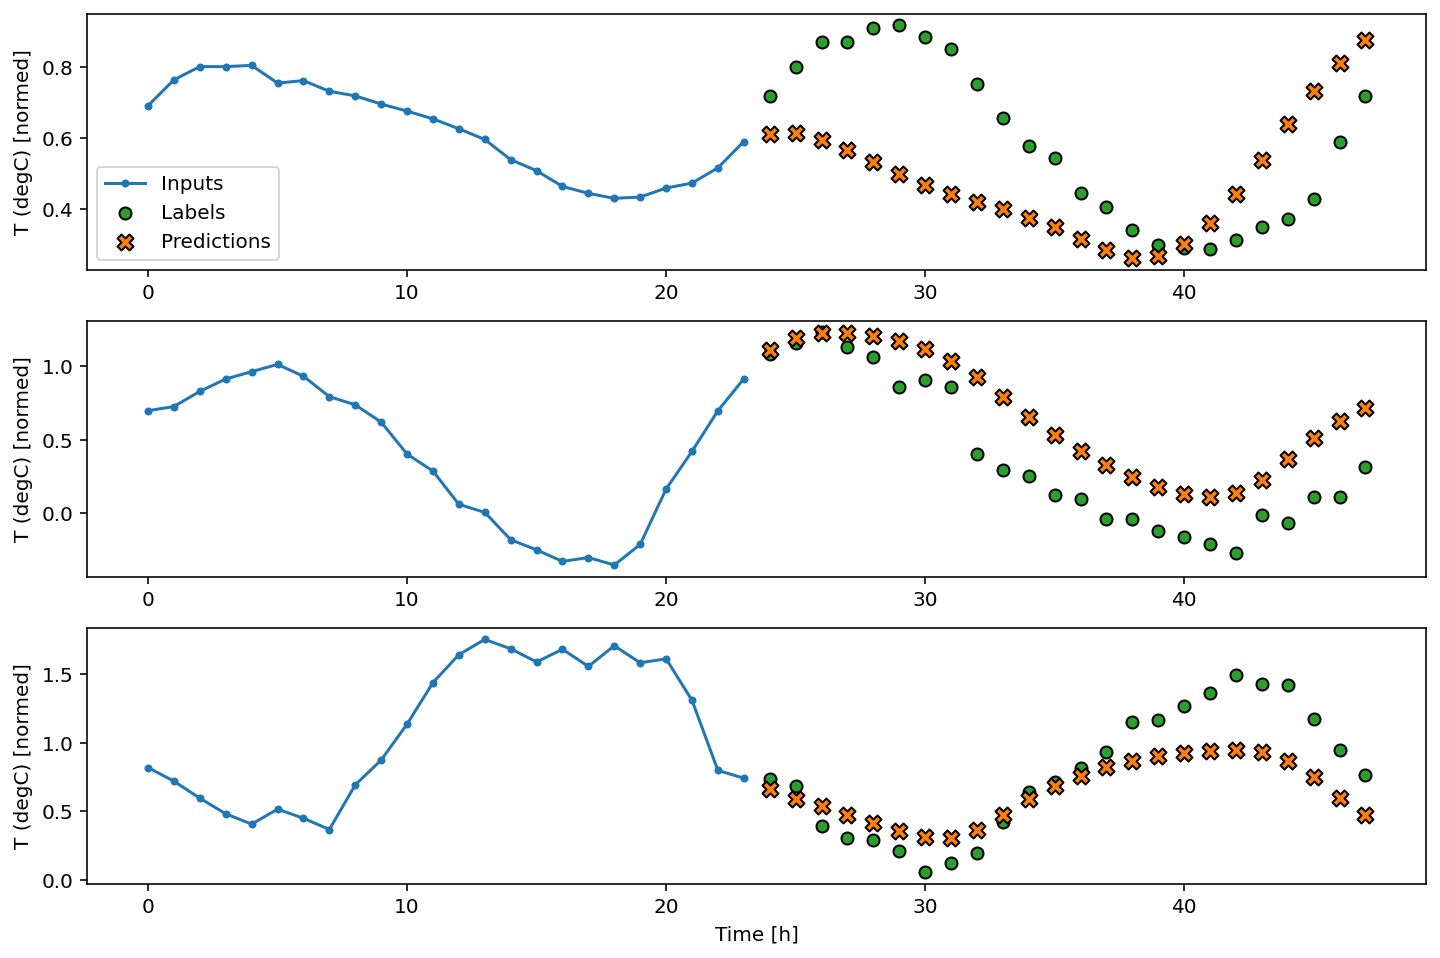

In [254]:
feedback = FeedBack(num_features, OUT_STEPS)
compile_and_fit(feedback, multi_window)

multi_val_performance['AR LSTM'] = feedback.evaluate(multi_window.val)
multi_test_performance['AR LSTM'] = feedback.evaluate(multi_window.test)
multi_window.plot(feedback)
# save_fig('feedback_plot.png')

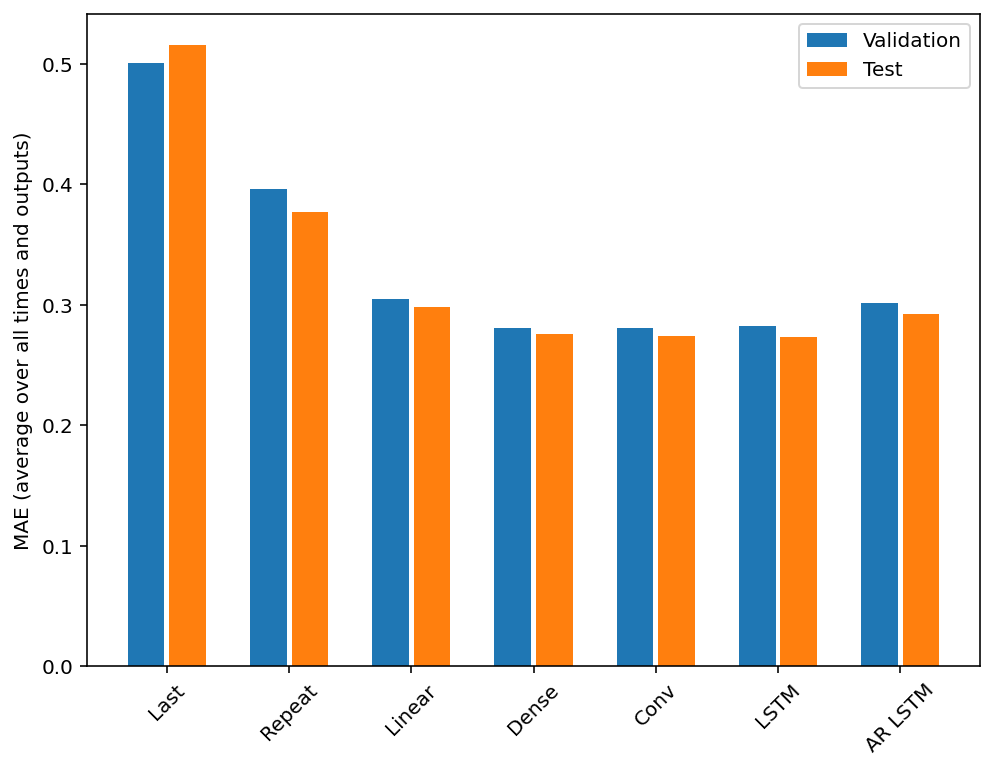

In [255]:
plot_performance(
    multi_val_performance, multi_test_performance,
    ylabel='MAE (average over all times and outputs)'
)
# save_fig('multi_step_performance.png')

In [256]:
for name, value in multi_test_performance.items():
    print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5156
Repeat  : 0.3774
Linear  : 0.2983
Dense   : 0.2756
Conv    : 0.2744
LSTM    : 0.2730
AR LSTM : 0.2922


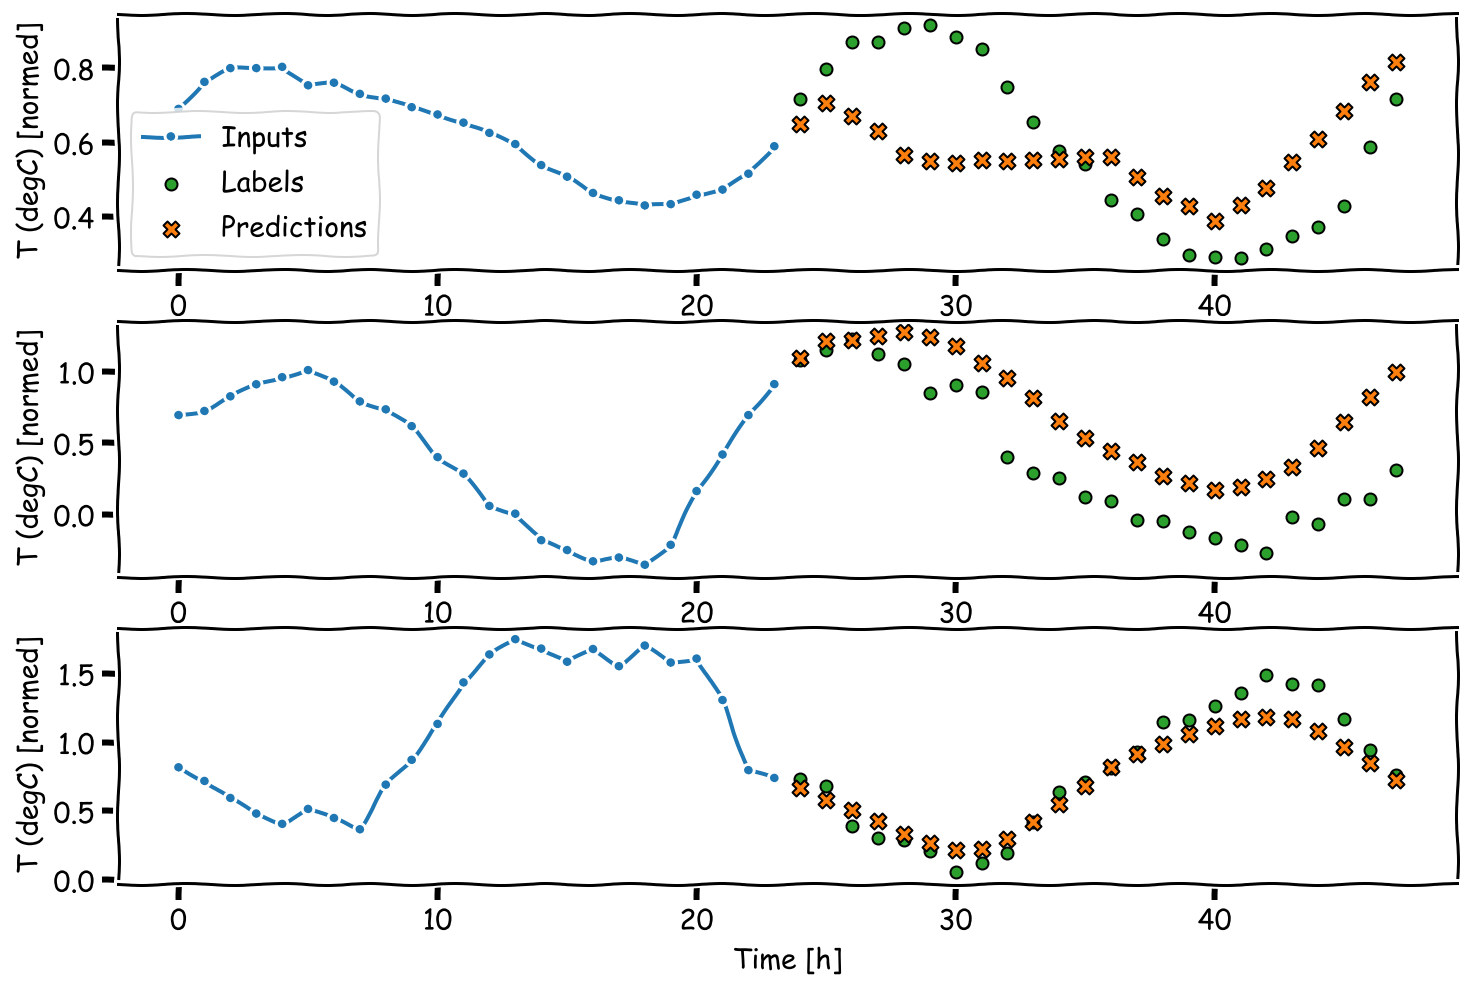

In [258]:
with plt.xkcd():
    multi_window.plot(multi_dense_model)
    save_fig('xkcd.png')